In [1]:
magnification_factor = ''
trainable_blocks = []
irun = 0

In [2]:
# Parameters
magnification_factor = "40X"
trainable_blocks = ["block3", "block4"]
irun = 5


In [3]:
irun = str(irun)

In [4]:
name = 'FINETUNING_'+ magnification_factor +'-BREAKHIS-Dataset-60-10-30-VGGINet'

path = './VGGINET-FT/%s/%s' % (name, irun)
!mkdir -p {path}

path

'./VGGINET-FT/FINETUNING_40X-BREAKHIS-Dataset-60-10-30-VGGINet/5'

In [5]:
tb_path = './tensorboard/' + magnification_factor + '/' + irun
tb_path

'./tensorboard/40X/5'

# Training

In [6]:
import tensorflow as tf
tf.version.VERSION, tf.config.list_physical_devices()

('2.3.0-rc1',
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
  PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
layer_name = 'block4_pool'
feature_ex_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output, name='vgg16_features')
feature_ex_model.trainable = False
feature_ex_model.summary()

Model: "vgg16_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [9]:
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

p1_layer = Lambda(vgg_preprocess, name='VGG_Preprocess')

image_input = Input((224, 224, 3), name='Image_Input')
p1_tensor = p1_layer(image_input)

out =feature_ex_model(p1_tensor)
feature_ex_model = Model(inputs=image_input, outputs=out)

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate,BatchNormalization,Activation 

def naive_inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = Concatenate()([conv1, conv3, conv5, pool])
    return layer_out

In [11]:
out = naive_inception_module(feature_ex_model.output, 64, 128, 32)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Flatten
num_classes = 2

bn1 = BatchNormalization(name='BN')(out)
f = Flatten()(bn1)
dropout = Dropout(0.4, name='Dropout')(f)
desne = Dense(num_classes, activation='softmax', name='Predictions')(dropout)

In [13]:
new_model = Model(inputs=feature_ex_model.input, outputs=desne)
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [14]:
from tensorflow import keras
opt = keras.optimizers.Adam(lr=0.001)

In [15]:
new_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = [
    # ModelCheckpoint(monitor='val_accuracy',filepath="./model-weights.{epoch:02d}-{val_accuracy:.6f}.hdf5", verbose=1, save_best_only=True)
]

In [17]:
from tensorflow.keras.callbacks import TensorBoard
callbacks += [TensorBoard(tb_path)]

In [18]:
import tensorflow as tf

image_size = (224, 340)
crop_size = (224, 224)
batch_size = 128

train_path = '../../Splitted_' + magnification_factor + '/train'
val_path = '../../Splitted_' + magnification_factor + '/val'
test_path = '../../Splitted_' + magnification_factor + '/test'

def dataset(ds_path, image_size, crop_size, batch_size, train):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=train, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)
    
    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)
    @tf.function
    def augment(images, labels):
        aug_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,
                                                               [image],
                                                               tf.float32), 
                               images)
        aug_images = tf.ensure_shape(aug_images, images.shape)
        return aug_images, labels
    
    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)
    @tf.function
    def crop(images, labels):
        cropped_images = crop_layer(images, training=train)
        return cropped_images, labels
    
    if train:
        ds = ds.map(augment, tf.data.experimental.AUTOTUNE)
    ds = ds.map(crop, tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

train_ds = dataset(train_path, image_size, crop_size, batch_size, train=True)
val_ds = dataset(val_path, image_size, crop_size, batch_size, train=False)
test_ds = dataset(test_path, image_size, crop_size, batch_size, train=False)

Found 1077 files belonging to 2 classes.


Found 179 files belonging to 2 classes.


Found 539 files belonging to 2 classes.


In [19]:
init_epochs=100

In [20]:
train_history = new_model.fit(train_ds, epochs=init_epochs, 
                              validation_data=val_ds,
                              verbose=1, callbacks=callbacks)

Epoch 1/100


1/9 [==>...........................] - ETA: 0s - loss: 1.2497 - accuracy: 0.4297

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2/9 [=====>........................] - ETA: 6s - loss: 6.1487 - accuracy: 0.5742

3/9 [=========>....................] - ETA: 13s - loss: 8.4815 - accuracy: 0.6042

4/9 [============>.................] - ETA: 9s - loss: 7.0607 - accuracy: 0.6543 

5/9 [===============>..............] - ETA: 7s - loss: 6.6606 - accuracy: 0.6672

6/9 [===================>..........] - ETA: 4s - loss: 7.6780 - accuracy: 0.6341

7/9 [======================>.......] - ETA: 3s - loss: 7.0911 - accuracy: 0.6462

8/9 [=========================>....] - ETA: 1s - loss: 6.5164 - accuracy: 0.6650

9/9 [==============================] - ETA: 0s - loss: 6.2340 - accuracy: 0.6769

9/9 [==============================] - 25s 3s/step - loss: 6.2340 - accuracy: 0.6769 - val_loss: 17.1129 - val_accuracy: 0.7263


Epoch 2/100


1/9 [==>...........................] - ETA: 0s - loss: 5.3255 - accuracy: 0.7656

2/9 [=====>........................] - ETA: 3s - loss: 5.0496 - accuracy: 0.7891

3/9 [=========>....................] - ETA: 8s - loss: 4.5080 - accuracy: 0.8125

4/9 [============>.................] - ETA: 10s - loss: 3.9452 - accuracy: 0.8301

5/9 [===============>..............] - ETA: 7s - loss: 3.7615 - accuracy: 0.8313 

6/9 [===================>..........] - ETA: 5s - loss: 3.3958 - accuracy: 0.8411

7/9 [======================>.......] - ETA: 3s - loss: 3.2744 - accuracy: 0.8449

8/9 [=========================>....] - ETA: 1s - loss: 3.1305 - accuracy: 0.8408

9/9 [==============================] - ETA: 0s - loss: 3.1384 - accuracy: 0.8394

9/9 [==============================] - 16s 2s/step - loss: 3.1384 - accuracy: 0.8394 - val_loss: 7.2201 - val_accuracy: 0.8715


Epoch 3/100


1/9 [==>...........................] - ETA: 0s - loss: 2.3849 - accuracy: 0.8125

2/9 [=====>........................] - ETA: 13s - loss: 2.6275 - accuracy: 0.8164

3/9 [=========>....................] - ETA: 10s - loss: 2.5746 - accuracy: 0.8229

4/9 [============>.................] - ETA: 9s - loss: 2.2671 - accuracy: 0.8438 

5/9 [===============>..............] - ETA: 7s - loss: 2.7608 - accuracy: 0.8328

6/9 [===================>..........] - ETA: 5s - loss: 2.5028 - accuracy: 0.8464

7/9 [======================>.......] - ETA: 3s - loss: 2.3135 - accuracy: 0.8516

8/9 [=========================>....] - ETA: 1s - loss: 2.1818 - accuracy: 0.8604

9/9 [==============================] - ETA: 0s - loss: 2.1281 - accuracy: 0.8654

9/9 [==============================] - 16s 2s/step - loss: 2.1281 - accuracy: 0.8654 - val_loss: 3.3828 - val_accuracy: 0.8603


Epoch 4/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0940 - accuracy: 0.9062

2/9 [=====>........................] - ETA: 14s - loss: 1.2830 - accuracy: 0.8828

3/9 [=========>....................] - ETA: 10s - loss: 1.4017 - accuracy: 0.8802

4/9 [============>.................] - ETA: 10s - loss: 1.2155 - accuracy: 0.8945

5/9 [===============>..............] - ETA: 7s - loss: 1.1881 - accuracy: 0.8984 

6/9 [===================>..........] - ETA: 5s - loss: 1.2028 - accuracy: 0.8971

7/9 [======================>.......] - ETA: 3s - loss: 1.3005 - accuracy: 0.8906

8/9 [=========================>....] - ETA: 1s - loss: 1.3397 - accuracy: 0.8848

9/9 [==============================] - ETA: 0s - loss: 1.3497 - accuracy: 0.8830

9/9 [==============================] - 16s 2s/step - loss: 1.3497 - accuracy: 0.8830 - val_loss: 2.7407 - val_accuracy: 0.8659


Epoch 5/100


1/9 [==>...........................] - ETA: 0s - loss: 1.3509 - accuracy: 0.9219

2/9 [=====>........................] - ETA: 13s - loss: 1.2250 - accuracy: 0.9180

3/9 [=========>....................] - ETA: 9s - loss: 1.0722 - accuracy: 0.9219 

4/9 [============>.................] - ETA: 9s - loss: 0.9305 - accuracy: 0.9297

5/9 [===============>..............] - ETA: 7s - loss: 1.0754 - accuracy: 0.9219

6/9 [===================>..........] - ETA: 5s - loss: 1.0821 - accuracy: 0.9206

7/9 [======================>.......] - ETA: 3s - loss: 1.1173 - accuracy: 0.9185

8/9 [=========================>....] - ETA: 1s - loss: 1.0530 - accuracy: 0.9229

9/9 [==============================] - ETA: 0s - loss: 1.0528 - accuracy: 0.9211

9/9 [==============================] - 16s 2s/step - loss: 1.0528 - accuracy: 0.9211 - val_loss: 3.8887 - val_accuracy: 0.8380


Epoch 6/100


1/9 [==>...........................] - ETA: 0s - loss: 1.6670 - accuracy: 0.8828

2/9 [=====>........................] - ETA: 12s - loss: 1.2281 - accuracy: 0.8984

3/9 [=========>....................] - ETA: 9s - loss: 1.2725 - accuracy: 0.8984 

4/9 [============>.................] - ETA: 10s - loss: 1.2725 - accuracy: 0.8887

5/9 [===============>..............] - ETA: 7s - loss: 1.2262 - accuracy: 0.8906 

6/9 [===================>..........] - ETA: 5s - loss: 1.1678 - accuracy: 0.8958

7/9 [======================>.......] - ETA: 3s - loss: 1.0904 - accuracy: 0.9007

8/9 [=========================>....] - ETA: 1s - loss: 1.0587 - accuracy: 0.9033

9/9 [==============================] - ETA: 0s - loss: 1.0630 - accuracy: 0.9025

9/9 [==============================] - 16s 2s/step - loss: 1.0630 - accuracy: 0.9025 - val_loss: 1.4117 - val_accuracy: 0.9050


Epoch 7/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6768 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 3s - loss: 0.7977 - accuracy: 0.9258

3/9 [=========>....................] - ETA: 7s - loss: 0.7371 - accuracy: 0.9297

4/9 [============>.................] - ETA: 6s - loss: 0.7710 - accuracy: 0.9277

5/9 [===============>..............] - ETA: 6s - loss: 0.7849 - accuracy: 0.9250

6/9 [===================>..........] - ETA: 5s - loss: 0.7377 - accuracy: 0.9245

7/9 [======================>.......] - ETA: 3s - loss: 0.7227 - accuracy: 0.9241

8/9 [=========================>....] - ETA: 1s - loss: 0.7334 - accuracy: 0.9248

9/9 [==============================] - ETA: 0s - loss: 0.7135 - accuracy: 0.9276

9/9 [==============================] - 16s 2s/step - loss: 0.7135 - accuracy: 0.9276 - val_loss: 1.5731 - val_accuracy: 0.9162


Epoch 8/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7390 - accuracy: 0.9141

2/9 [=====>........................] - ETA: 13s - loss: 0.6064 - accuracy: 0.9258

3/9 [=========>....................] - ETA: 9s - loss: 0.6222 - accuracy: 0.9193 

4/9 [============>.................] - ETA: 9s - loss: 0.5164 - accuracy: 0.9258

5/9 [===============>..............] - ETA: 7s - loss: 0.5230 - accuracy: 0.9297

6/9 [===================>..........] - ETA: 4s - loss: 0.5035 - accuracy: 0.9349

7/9 [======================>.......] - ETA: 3s - loss: 0.4899 - accuracy: 0.9364

8/9 [=========================>....] - ETA: 1s - loss: 0.5146 - accuracy: 0.9375

9/9 [==============================] - ETA: 0s - loss: 0.5882 - accuracy: 0.9341

9/9 [==============================] - 15s 2s/step - loss: 0.5882 - accuracy: 0.9341 - val_loss: 1.1818 - val_accuracy: 0.9106


Epoch 9/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3321 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 10s - loss: 0.2719 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 8s - loss: 0.4987 - accuracy: 0.9479 

4/9 [============>.................] - ETA: 9s - loss: 0.4895 - accuracy: 0.9492

5/9 [===============>..............] - ETA: 7s - loss: 0.6190 - accuracy: 0.9438

6/9 [===================>..........] - ETA: 4s - loss: 0.6804 - accuracy: 0.9323

7/9 [======================>.......] - ETA: 3s - loss: 0.6624 - accuracy: 0.9353

8/9 [=========================>....] - ETA: 1s - loss: 0.6641 - accuracy: 0.9336

9/9 [==============================] - ETA: 0s - loss: 0.6862 - accuracy: 0.9331

9/9 [==============================] - 15s 2s/step - loss: 0.6862 - accuracy: 0.9331 - val_loss: 1.4408 - val_accuracy: 0.9162


Epoch 10/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0483 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.4866 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 9s - loss: 0.4558 - accuracy: 0.9531 

4/9 [============>.................] - ETA: 10s - loss: 0.4113 - accuracy: 0.9570

5/9 [===============>..............] - ETA: 7s - loss: 0.5001 - accuracy: 0.9469 

6/9 [===================>..........] - ETA: 5s - loss: 0.4539 - accuracy: 0.9492

7/9 [======================>.......] - ETA: 3s - loss: 0.4220 - accuracy: 0.9487

8/9 [=========================>....] - ETA: 1s - loss: 0.4542 - accuracy: 0.9453

9/9 [==============================] - ETA: 0s - loss: 0.4831 - accuracy: 0.9452

9/9 [==============================] - 16s 2s/step - loss: 0.4831 - accuracy: 0.9452 - val_loss: 1.7657 - val_accuracy: 0.9218


Epoch 11/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6387 - accuracy: 0.9062

2/9 [=====>........................] - ETA: 13s - loss: 0.7484 - accuracy: 0.9180

3/9 [=========>....................] - ETA: 10s - loss: 0.9146 - accuracy: 0.9141

4/9 [============>.................] - ETA: 9s - loss: 0.7054 - accuracy: 0.9316 

5/9 [===============>..............] - ETA: 7s - loss: 0.6177 - accuracy: 0.9375

6/9 [===================>..........] - ETA: 5s - loss: 0.6700 - accuracy: 0.9310

7/9 [======================>.......] - ETA: 3s - loss: 0.6767 - accuracy: 0.9319

8/9 [=========================>....] - ETA: 1s - loss: 0.6697 - accuracy: 0.9297

9/9 [==============================] - ETA: 0s - loss: 0.6766 - accuracy: 0.9304

9/9 [==============================] - 16s 2s/step - loss: 0.6766 - accuracy: 0.9304 - val_loss: 1.0178 - val_accuracy: 0.9218


Epoch 12/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3785 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 10s - loss: 0.6535 - accuracy: 0.9258

3/9 [=========>....................] - ETA: 8s - loss: 0.6424 - accuracy: 0.9323 

4/9 [============>.................] - ETA: 9s - loss: 0.5915 - accuracy: 0.9395

5/9 [===============>..............] - ETA: 7s - loss: 0.5933 - accuracy: 0.9391

6/9 [===================>..........] - ETA: 4s - loss: 0.6297 - accuracy: 0.9310

7/9 [======================>.......] - ETA: 3s - loss: 0.5894 - accuracy: 0.9353

8/9 [=========================>....] - ETA: 1s - loss: 0.5713 - accuracy: 0.9365

9/9 [==============================] - ETA: 0s - loss: 0.6009 - accuracy: 0.9341

9/9 [==============================] - 15s 2s/step - loss: 0.6009 - accuracy: 0.9341 - val_loss: 1.2904 - val_accuracy: 0.9497


Epoch 13/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6599 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.5849 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 9s - loss: 0.6253 - accuracy: 0.9401 

4/9 [============>.................] - ETA: 9s - loss: 0.5897 - accuracy: 0.9434

5/9 [===============>..............] - ETA: 7s - loss: 0.5344 - accuracy: 0.9453

6/9 [===================>..........] - ETA: 5s - loss: 0.5827 - accuracy: 0.9440

7/9 [======================>.......] - ETA: 3s - loss: 0.5299 - accuracy: 0.9475

8/9 [=========================>....] - ETA: 1s - loss: 0.5260 - accuracy: 0.9492

9/9 [==============================] - ETA: 0s - loss: 0.5282 - accuracy: 0.9471

9/9 [==============================] - 16s 2s/step - loss: 0.5282 - accuracy: 0.9471 - val_loss: 1.0768 - val_accuracy: 0.9274


Epoch 14/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5510 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 16s - loss: 0.4438 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 15s - loss: 0.4307 - accuracy: 0.9505

4/9 [============>.................] - ETA: 12s - loss: 0.5684 - accuracy: 0.9453

5/9 [===============>..............] - ETA: 8s - loss: 0.5157 - accuracy: 0.9484 

6/9 [===================>..........] - ETA: 5s - loss: 0.5372 - accuracy: 0.9466

7/9 [======================>.......] - ETA: 3s - loss: 0.5343 - accuracy: 0.9453

8/9 [=========================>....] - ETA: 1s - loss: 0.5086 - accuracy: 0.9473

9/9 [==============================] - ETA: 0s - loss: 0.5758 - accuracy: 0.9406

9/9 [==============================] - 17s 2s/step - loss: 0.5758 - accuracy: 0.9406 - val_loss: 1.7484 - val_accuracy: 0.9330


Epoch 15/100


1/9 [==>...........................] - ETA: 0s - loss: 1.1832 - accuracy: 0.8984

2/9 [=====>........................] - ETA: 13s - loss: 0.9724 - accuracy: 0.9062

3/9 [=========>....................] - ETA: 9s - loss: 0.7116 - accuracy: 0.9297 

4/9 [============>.................] - ETA: 9s - loss: 0.5997 - accuracy: 0.9375

5/9 [===============>..............] - ETA: 7s - loss: 0.5798 - accuracy: 0.9391

6/9 [===================>..........] - ETA: 5s - loss: 0.5773 - accuracy: 0.9388

7/9 [======================>.......] - ETA: 3s - loss: 0.6022 - accuracy: 0.9431

8/9 [=========================>....] - ETA: 1s - loss: 0.7116 - accuracy: 0.9385

9/9 [==============================] - ETA: 0s - loss: 0.6808 - accuracy: 0.9406

9/9 [==============================] - 16s 2s/step - loss: 0.6808 - accuracy: 0.9406 - val_loss: 1.8850 - val_accuracy: 0.9274


Epoch 16/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1705 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.8379 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 10s - loss: 0.8104 - accuracy: 0.9505

4/9 [============>.................] - ETA: 9s - loss: 0.8021 - accuracy: 0.9492 

5/9 [===============>..............] - ETA: 7s - loss: 0.7539 - accuracy: 0.9469

6/9 [===================>..........] - ETA: 5s - loss: 0.6799 - accuracy: 0.9492

7/9 [======================>.......] - ETA: 3s - loss: 0.7611 - accuracy: 0.9453

8/9 [=========================>....] - ETA: 1s - loss: 0.7128 - accuracy: 0.9463

9/9 [==============================] - ETA: 0s - loss: 0.7180 - accuracy: 0.9443

9/9 [==============================] - 16s 2s/step - loss: 0.7180 - accuracy: 0.9443 - val_loss: 1.2684 - val_accuracy: 0.9274


Epoch 17/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3296 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 3s - loss: 0.5579 - accuracy: 0.9297

3/9 [=========>....................] - ETA: 9s - loss: 0.4864 - accuracy: 0.9453

4/9 [============>.................] - ETA: 10s - loss: 0.4713 - accuracy: 0.9492

5/9 [===============>..............] - ETA: 7s - loss: 0.5492 - accuracy: 0.9516 

6/9 [===================>..........] - ETA: 5s - loss: 0.6676 - accuracy: 0.9453

7/9 [======================>.......] - ETA: 3s - loss: 0.7213 - accuracy: 0.9420

8/9 [=========================>....] - ETA: 1s - loss: 0.7039 - accuracy: 0.9414

9/9 [==============================] - ETA: 0s - loss: 0.6868 - accuracy: 0.9434

9/9 [==============================] - 16s 2s/step - loss: 0.6868 - accuracy: 0.9434 - val_loss: 1.9498 - val_accuracy: 0.9274


Epoch 18/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3252 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.4019 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 10s - loss: 0.4931 - accuracy: 0.9453

4/9 [============>.................] - ETA: 9s - loss: 0.4476 - accuracy: 0.9473 

5/9 [===============>..............] - ETA: 7s - loss: 0.4181 - accuracy: 0.9516

6/9 [===================>..........] - ETA: 4s - loss: 0.3916 - accuracy: 0.9544

7/9 [======================>.......] - ETA: 3s - loss: 0.4957 - accuracy: 0.9531

8/9 [=========================>....] - ETA: 1s - loss: 0.5406 - accuracy: 0.9502

9/9 [==============================] - ETA: 0s - loss: 0.5742 - accuracy: 0.9480

9/9 [==============================] - 15s 2s/step - loss: 0.5742 - accuracy: 0.9480 - val_loss: 1.4643 - val_accuracy: 0.9441


Epoch 19/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3284 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.2660 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.3568 - accuracy: 0.9635 

4/9 [============>.................] - ETA: 7s - loss: 0.4499 - accuracy: 0.9570

5/9 [===============>..............] - ETA: 7s - loss: 0.5120 - accuracy: 0.9563

6/9 [===================>..........] - ETA: 5s - loss: 0.5413 - accuracy: 0.9531

7/9 [======================>.......] - ETA: 3s - loss: 0.5131 - accuracy: 0.9531

8/9 [=========================>....] - ETA: 1s - loss: 0.5172 - accuracy: 0.9502

9/9 [==============================] - ETA: 0s - loss: 0.5271 - accuracy: 0.9508

9/9 [==============================] - 16s 2s/step - loss: 0.5271 - accuracy: 0.9508 - val_loss: 0.7667 - val_accuracy: 0.9609


Epoch 20/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2615 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.2121 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.2367 - accuracy: 0.9661

4/9 [============>.................] - ETA: 10s - loss: 0.5025 - accuracy: 0.9551

5/9 [===============>..............] - ETA: 7s - loss: 0.6179 - accuracy: 0.9469 

6/9 [===================>..........] - ETA: 5s - loss: 0.5723 - accuracy: 0.9518

7/9 [======================>.......] - ETA: 3s - loss: 0.6652 - accuracy: 0.9475

8/9 [=========================>....] - ETA: 1s - loss: 0.6644 - accuracy: 0.9453

9/9 [==============================] - ETA: 0s - loss: 0.6419 - accuracy: 0.9461

9/9 [==============================] - 16s 2s/step - loss: 0.6419 - accuracy: 0.9461 - val_loss: 0.9730 - val_accuracy: 0.9441


Epoch 21/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3006 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.4734 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 9s - loss: 0.5283 - accuracy: 0.9531 

4/9 [============>.................] - ETA: 10s - loss: 0.5750 - accuracy: 0.9531

5/9 [===============>..............] - ETA: 7s - loss: 0.7053 - accuracy: 0.9516 

6/9 [===================>..........] - ETA: 5s - loss: 0.6041 - accuracy: 0.9570

7/9 [======================>.......] - ETA: 3s - loss: 0.5879 - accuracy: 0.9576

8/9 [=========================>....] - ETA: 1s - loss: 0.6565 - accuracy: 0.9512

9/9 [==============================] - ETA: 0s - loss: 0.6467 - accuracy: 0.9508

9/9 [==============================] - 16s 2s/step - loss: 0.6467 - accuracy: 0.9508 - val_loss: 1.7764 - val_accuracy: 0.9385


Epoch 22/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5768 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 10s - loss: 0.4587 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 8s - loss: 0.4260 - accuracy: 0.9635 

4/9 [============>.................] - ETA: 8s - loss: 0.4052 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 7s - loss: 0.4749 - accuracy: 0.9609

6/9 [===================>..........] - ETA: 4s - loss: 0.4203 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 3s - loss: 0.4276 - accuracy: 0.9632

8/9 [=========================>....] - ETA: 1s - loss: 0.4087 - accuracy: 0.9629

9/9 [==============================] - ETA: 0s - loss: 0.3937 - accuracy: 0.9638

9/9 [==============================] - 15s 2s/step - loss: 0.3937 - accuracy: 0.9638 - val_loss: 1.4795 - val_accuracy: 0.9385


Epoch 23/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4200 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 14s - loss: 0.5035 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 9s - loss: 0.3442 - accuracy: 0.9661 

4/9 [============>.................] - ETA: 9s - loss: 0.4260 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 7s - loss: 0.4188 - accuracy: 0.9641

6/9 [===================>..........] - ETA: 5s - loss: 0.4264 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 3s - loss: 0.4525 - accuracy: 0.9632

8/9 [=========================>....] - ETA: 1s - loss: 0.4208 - accuracy: 0.9639

9/9 [==============================] - ETA: 0s - loss: 0.4426 - accuracy: 0.9629

9/9 [==============================] - 16s 2s/step - loss: 0.4426 - accuracy: 0.9629 - val_loss: 1.0359 - val_accuracy: 0.9497


Epoch 24/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3913 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.2579 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.2082 - accuracy: 0.9766 

4/9 [============>.................] - ETA: 9s - loss: 0.2323 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.2694 - accuracy: 0.9734

6/9 [===================>..........] - ETA: 4s - loss: 0.2712 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.2563 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.2714 - accuracy: 0.9727

9/9 [==============================] - ETA: 0s - loss: 0.2614 - accuracy: 0.9731

9/9 [==============================] - 15s 2s/step - loss: 0.2614 - accuracy: 0.9731 - val_loss: 1.4061 - val_accuracy: 0.9385


Epoch 25/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1066 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.4961 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 9s - loss: 0.4114 - accuracy: 0.9688 

4/9 [============>.................] - ETA: 9s - loss: 0.4347 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 7s - loss: 0.4059 - accuracy: 0.9656

6/9 [===================>..........] - ETA: 4s - loss: 0.4825 - accuracy: 0.9609

7/9 [======================>.......] - ETA: 3s - loss: 0.4816 - accuracy: 0.9598

8/9 [=========================>....] - ETA: 1s - loss: 0.4486 - accuracy: 0.9629

9/9 [==============================] - ETA: 0s - loss: 0.5149 - accuracy: 0.9601

9/9 [==============================] - 15s 2s/step - loss: 0.5149 - accuracy: 0.9601 - val_loss: 1.0343 - val_accuracy: 0.9497


Epoch 26/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6122 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.5239 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 9s - loss: 0.3977 - accuracy: 0.9635 

4/9 [============>.................] - ETA: 9s - loss: 0.3278 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.3408 - accuracy: 0.9672

6/9 [===================>..........] - ETA: 4s - loss: 0.4098 - accuracy: 0.9661

7/9 [======================>.......] - ETA: 3s - loss: 0.3820 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.3844 - accuracy: 0.9688

9/9 [==============================] - ETA: 0s - loss: 0.4138 - accuracy: 0.9666

9/9 [==============================] - 15s 2s/step - loss: 0.4138 - accuracy: 0.9666 - val_loss: 0.7706 - val_accuracy: 0.9553


Epoch 27/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0905 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.1131 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.1202 - accuracy: 0.9792 

4/9 [============>.................] - ETA: 10s - loss: 0.1139 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.1815 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.1865 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.2073 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.2362 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.2753 - accuracy: 0.9721

9/9 [==============================] - 16s 2s/step - loss: 0.2753 - accuracy: 0.9721 - val_loss: 0.9289 - val_accuracy: 0.9274


Epoch 28/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8148 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.8351 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 10s - loss: 0.6138 - accuracy: 0.9583

4/9 [============>.................] - ETA: 10s - loss: 0.5491 - accuracy: 0.9570

5/9 [===============>..............] - ETA: 7s - loss: 0.5240 - accuracy: 0.9578 

6/9 [===================>..........] - ETA: 5s - loss: 0.4367 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 3s - loss: 0.4425 - accuracy: 0.9643

8/9 [=========================>....] - ETA: 1s - loss: 0.4548 - accuracy: 0.9619

9/9 [==============================] - ETA: 0s - loss: 0.5457 - accuracy: 0.9582

9/9 [==============================] - 16s 2s/step - loss: 0.5457 - accuracy: 0.9582 - val_loss: 2.6470 - val_accuracy: 0.9050


Epoch 29/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1036 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 3s - loss: 0.0786 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 7s - loss: 0.3086 - accuracy: 0.9714

4/9 [============>.................] - ETA: 6s - loss: 0.2742 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 6s - loss: 0.2705 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 4s - loss: 0.2819 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2676 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.3280 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.3213 - accuracy: 0.9703

9/9 [==============================] - 15s 2s/step - loss: 0.3213 - accuracy: 0.9703 - val_loss: 1.3695 - val_accuracy: 0.9385


Epoch 30/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5586 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.6799 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 10s - loss: 0.6190 - accuracy: 0.9557

4/9 [============>.................] - ETA: 10s - loss: 0.5733 - accuracy: 0.9570

5/9 [===============>..............] - ETA: 7s - loss: 0.4842 - accuracy: 0.9609 

6/9 [===================>..........] - ETA: 5s - loss: 0.4315 - accuracy: 0.9661

7/9 [======================>.......] - ETA: 3s - loss: 0.4037 - accuracy: 0.9665

8/9 [=========================>....] - ETA: 1s - loss: 0.4884 - accuracy: 0.9600

9/9 [==============================] - ETA: 0s - loss: 0.4934 - accuracy: 0.9601

9/9 [==============================] - 16s 2s/step - loss: 0.4934 - accuracy: 0.9601 - val_loss: 1.1585 - val_accuracy: 0.9553


Epoch 31/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1378 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.3974 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 12s - loss: 0.3151 - accuracy: 0.9714

4/9 [============>.................] - ETA: 10s - loss: 0.2738 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 8s - loss: 0.2350 - accuracy: 0.9703 

6/9 [===================>..........] - ETA: 5s - loss: 0.2281 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.2155 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.2672 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.2789 - accuracy: 0.9694

9/9 [==============================] - 17s 2s/step - loss: 0.2789 - accuracy: 0.9694 - val_loss: 1.8233 - val_accuracy: 0.9106


Epoch 32/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0751 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2437 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.1919 - accuracy: 0.9740

4/9 [============>.................] - ETA: 10s - loss: 0.1665 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.2339 - accuracy: 0.9719 

6/9 [===================>..........] - ETA: 5s - loss: 0.2620 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.3167 - accuracy: 0.9688

8/9 [=========================>....] - ETA: 1s - loss: 0.2771 - accuracy: 0.9727

9/9 [==============================] - ETA: 0s - loss: 0.2797 - accuracy: 0.9721

9/9 [==============================] - 16s 2s/step - loss: 0.2797 - accuracy: 0.9721 - val_loss: 1.0109 - val_accuracy: 0.9553


Epoch 33/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3194 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.2631 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 9s - loss: 0.3422 - accuracy: 0.9740 

4/9 [============>.................] - ETA: 7s - loss: 0.3221 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.3334 - accuracy: 0.9688

6/9 [===================>..........] - ETA: 5s - loss: 0.3515 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.3656 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.3979 - accuracy: 0.9688

9/9 [==============================] - ETA: 0s - loss: 0.3783 - accuracy: 0.9703

9/9 [==============================] - 16s 2s/step - loss: 0.3783 - accuracy: 0.9703 - val_loss: 1.4038 - val_accuracy: 0.9441


Epoch 34/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1030 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.2699 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.2586 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.2370 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.2610 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.3076 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.2861 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.2703 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.2637 - accuracy: 0.9759

9/9 [==============================] - 16s 2s/step - loss: 0.2637 - accuracy: 0.9759 - val_loss: 1.3936 - val_accuracy: 0.9497


Epoch 35/100


1/9 [==>...........................] - ETA: 0s - loss: 1.9124e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.5224 - accuracy: 0.9648   

3/9 [=========>....................] - ETA: 10s - loss: 0.3602 - accuracy: 0.9740

4/9 [============>.................] - ETA: 10s - loss: 0.2907 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.2490 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.2408 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2443 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.3151 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.3576 - accuracy: 0.9721

9/9 [==============================] - 16s 2s/step - loss: 0.3576 - accuracy: 0.9721 - val_loss: 1.2605 - val_accuracy: 0.9330


Epoch 36/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4028 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 10s - loss: 0.3725 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 8s - loss: 0.2893 - accuracy: 0.9688 

4/9 [============>.................] - ETA: 8s - loss: 0.3397 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.4063 - accuracy: 0.9688

6/9 [===================>..........] - ETA: 5s - loss: 0.4852 - accuracy: 0.9674

7/9 [======================>.......] - ETA: 3s - loss: 0.4611 - accuracy: 0.9665

8/9 [=========================>....] - ETA: 1s - loss: 0.4620 - accuracy: 0.9648

9/9 [==============================] - ETA: 0s - loss: 0.5449 - accuracy: 0.9629

9/9 [==============================] - 16s 2s/step - loss: 0.5449 - accuracy: 0.9629 - val_loss: 1.3585 - val_accuracy: 0.9385


Epoch 37/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3060 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.7329 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 10s - loss: 0.4951 - accuracy: 0.9609

4/9 [============>.................] - ETA: 10s - loss: 0.4110 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 7s - loss: 0.4140 - accuracy: 0.9656 

6/9 [===================>..........] - ETA: 5s - loss: 0.3854 - accuracy: 0.9635

7/9 [======================>.......] - ETA: 3s - loss: 0.4018 - accuracy: 0.9609

8/9 [=========================>....] - ETA: 1s - loss: 0.3916 - accuracy: 0.9600

9/9 [==============================] - ETA: 0s - loss: 0.3819 - accuracy: 0.9601

9/9 [==============================] - 16s 2s/step - loss: 0.3819 - accuracy: 0.9601 - val_loss: 2.1616 - val_accuracy: 0.9162


Epoch 38/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7506 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.5413 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 9s - loss: 0.5873 - accuracy: 0.9661 

4/9 [============>.................] - ETA: 10s - loss: 0.7060 - accuracy: 0.9590

5/9 [===============>..............] - ETA: 7s - loss: 0.6487 - accuracy: 0.9609 

6/9 [===================>..........] - ETA: 5s - loss: 0.6495 - accuracy: 0.9622

7/9 [======================>.......] - ETA: 3s - loss: 0.6812 - accuracy: 0.9554

8/9 [=========================>....] - ETA: 1s - loss: 0.5961 - accuracy: 0.9609

9/9 [==============================] - ETA: 0s - loss: 0.5692 - accuracy: 0.9619

9/9 [==============================] - 16s 2s/step - loss: 0.5692 - accuracy: 0.9619 - val_loss: 1.7115 - val_accuracy: 0.9274


Epoch 39/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1672 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.2180 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 9s - loss: 0.1459 - accuracy: 0.9818 

4/9 [============>.................] - ETA: 10s - loss: 0.2538 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.2121 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.2448 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.3015 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.2984 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.2837 - accuracy: 0.9721

9/9 [==============================] - 16s 2s/step - loss: 0.2837 - accuracy: 0.9721 - val_loss: 1.4713 - val_accuracy: 0.9497


Epoch 40/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3473 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.3621 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 15s - loss: 0.2851 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.3411 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.3728 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.4070 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.4371 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.4610 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.5034 - accuracy: 0.9731

9/9 [==============================] - 16s 2s/step - loss: 0.5034 - accuracy: 0.9731 - val_loss: 1.5159 - val_accuracy: 0.9553


Epoch 41/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1014 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.3981 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.4820 - accuracy: 0.9661 

4/9 [============>.................] - ETA: 9s - loss: 0.4014 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.3990 - accuracy: 0.9688

6/9 [===================>..........] - ETA: 5s - loss: 0.3690 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.3958 - accuracy: 0.9688

8/9 [=========================>....] - ETA: 1s - loss: 0.3721 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.3589 - accuracy: 0.9703

9/9 [==============================] - 16s 2s/step - loss: 0.3589 - accuracy: 0.9703 - val_loss: 1.1961 - val_accuracy: 0.9609


Epoch 42/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4059 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.5163 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.4411 - accuracy: 0.9714

4/9 [============>.................] - ETA: 10s - loss: 0.4379 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 8s - loss: 0.3558 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.3365 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.3465 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.3131 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.3605 - accuracy: 0.9740

9/9 [==============================] - 16s 2s/step - loss: 0.3605 - accuracy: 0.9740 - val_loss: 0.9379 - val_accuracy: 0.9497


Epoch 43/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3489 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.1799 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.2099 - accuracy: 0.9870

4/9 [============>.................] - ETA: 9s - loss: 0.2418 - accuracy: 0.9844 

5/9 [===============>..............] - ETA: 7s - loss: 0.2685 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 5s - loss: 0.2751 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.3309 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.4657 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.4479 - accuracy: 0.9740

9/9 [==============================] - 16s 2s/step - loss: 0.4479 - accuracy: 0.9740 - val_loss: 0.7085 - val_accuracy: 0.9609


Epoch 44/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0741 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.2387 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.2430 - accuracy: 0.9766 

4/9 [============>.................] - ETA: 9s - loss: 0.2045 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.1738 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 5s - loss: 0.2571 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.2327 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.2259 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.2470 - accuracy: 0.9768

9/9 [==============================] - 16s 2s/step - loss: 0.2470 - accuracy: 0.9768 - val_loss: 1.0328 - val_accuracy: 0.9497


Epoch 45/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5566 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 10s - loss: 0.6325 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 9s - loss: 0.5734 - accuracy: 0.9609 

4/9 [============>.................] - ETA: 8s - loss: 0.4570 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 6s - loss: 0.5030 - accuracy: 0.9688

6/9 [===================>..........] - ETA: 4s - loss: 0.5134 - accuracy: 0.9688

7/9 [======================>.......] - ETA: 3s - loss: 0.4521 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.3956 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.3762 - accuracy: 0.9749

9/9 [==============================] - 15s 2s/step - loss: 0.3762 - accuracy: 0.9749 - val_loss: 1.1666 - val_accuracy: 0.9497


Epoch 46/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7767 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.7505 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.5431 - accuracy: 0.9688

4/9 [============>.................] - ETA: 10s - loss: 0.4392 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 8s - loss: 0.3748 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.3512 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.3402 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.3296 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.3143 - accuracy: 0.9768

9/9 [==============================] - 16s 2s/step - loss: 0.3143 - accuracy: 0.9768 - val_loss: 1.6648 - val_accuracy: 0.9553


Epoch 47/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1838 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.1245 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 9s - loss: 0.4063 - accuracy: 0.9766 

4/9 [============>.................] - ETA: 10s - loss: 0.3341 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.3289 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.2741 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.2827 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2562 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2808 - accuracy: 0.9824

9/9 [==============================] - 16s 2s/step - loss: 0.2808 - accuracy: 0.9824 - val_loss: 1.2627 - val_accuracy: 0.9609


Epoch 48/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0702 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1127 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1993 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.2378 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 8s - loss: 0.3757 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.3348 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.3181 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.3110 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3126 - accuracy: 0.9777

9/9 [==============================] - 16s 2s/step - loss: 0.3126 - accuracy: 0.9777 - val_loss: 1.1906 - val_accuracy: 0.9553


Epoch 49/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0227 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.0670 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 7s - loss: 0.2155 - accuracy: 0.9766

4/9 [============>.................] - ETA: 6s - loss: 0.3392 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.2917 - accuracy: 0.9750

6/9 [===================>..........] - ETA: 5s - loss: 0.2597 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2612 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.2589 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.2483 - accuracy: 0.9786

9/9 [==============================] - 16s 2s/step - loss: 0.2483 - accuracy: 0.9786 - val_loss: 1.1611 - val_accuracy: 0.9441


Epoch 50/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2199 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2821 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.2188 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.3156 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.2640 - accuracy: 0.9703 

6/9 [===================>..........] - ETA: 5s - loss: 0.2694 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.3953 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.3728 - accuracy: 0.9717

9/9 [==============================] - ETA: 0s - loss: 0.3693 - accuracy: 0.9712

9/9 [==============================] - 16s 2s/step - loss: 0.3693 - accuracy: 0.9712 - val_loss: 1.3667 - val_accuracy: 0.9385


Epoch 51/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1733 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0867 - accuracy: 0.9961

3/9 [=========>....................] - ETA: 10s - loss: 0.0697 - accuracy: 0.9948

4/9 [============>.................] - ETA: 10s - loss: 0.1020 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 7s - loss: 0.1499 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.1932 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.2283 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2359 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2244 - accuracy: 0.9861

9/9 [==============================] - 16s 2s/step - loss: 0.2244 - accuracy: 0.9861 - val_loss: 1.3646 - val_accuracy: 0.9441


Epoch 52/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4866 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.2539 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.1923 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.1861 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.1832 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.2023 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.2042 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.1787 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2081 - accuracy: 0.9833

9/9 [==============================] - 16s 2s/step - loss: 0.2081 - accuracy: 0.9833 - val_loss: 1.3799 - val_accuracy: 0.9609


Epoch 53/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1793 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.2377 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.1805 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.1751 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.1555 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.2675 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.2674 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.2832 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.2754 - accuracy: 0.9749

9/9 [==============================] - 16s 2s/step - loss: 0.2754 - accuracy: 0.9749 - val_loss: 1.5963 - val_accuracy: 0.9609


Epoch 54/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3533 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2968 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.2658 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.2170 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.1875 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.1724 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.1595 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2108 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2004 - accuracy: 0.9861

9/9 [==============================] - 16s 2s/step - loss: 0.2004 - accuracy: 0.9861 - val_loss: 1.2737 - val_accuracy: 0.9385


Epoch 55/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3828 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 11s - loss: 0.5100 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 8s - loss: 0.3869 - accuracy: 0.9714 

4/9 [============>.................] - ETA: 9s - loss: 0.3579 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 6s - loss: 0.4164 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 4s - loss: 0.3690 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 2s - loss: 0.3850 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.3822 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.4278 - accuracy: 0.9759

9/9 [==============================] - 15s 2s/step - loss: 0.4278 - accuracy: 0.9759 - val_loss: 0.8468 - val_accuracy: 0.9609


Epoch 56/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1497 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.3286 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.2690 - accuracy: 0.9740

4/9 [============>.................] - ETA: 10s - loss: 0.2602 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.2183 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.2078 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.1782 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.1989 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.1916 - accuracy: 0.9824

9/9 [==============================] - 16s 2s/step - loss: 0.1916 - accuracy: 0.9824 - val_loss: 1.7812 - val_accuracy: 0.9497


Epoch 57/100


1/9 [==>...........................] - ETA: 0s - loss: 1.2639e-05 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.1238 - accuracy: 0.9844   

3/9 [=========>....................] - ETA: 10s - loss: 0.2429 - accuracy: 0.9740

4/9 [============>.................] - ETA: 10s - loss: 0.3269 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.2615 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.2471 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.2329 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.2819 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.2874 - accuracy: 0.9749

9/9 [==============================] - 16s 2s/step - loss: 0.2874 - accuracy: 0.9749 - val_loss: 3.6148 - val_accuracy: 0.9218


Epoch 58/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0810 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.4004 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 10s - loss: 0.5110 - accuracy: 0.9688

4/9 [============>.................] - ETA: 10s - loss: 0.4575 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.4263 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.4167 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.3791 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.3770 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.3746 - accuracy: 0.9759

9/9 [==============================] - 15s 2s/step - loss: 0.3746 - accuracy: 0.9759 - val_loss: 1.5910 - val_accuracy: 0.9497


Epoch 59/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1416 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.0903 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.2653 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.2506 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.2679 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.2233 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2101 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2255 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.2447 - accuracy: 0.9805

9/9 [==============================] - 16s 2s/step - loss: 0.2447 - accuracy: 0.9805 - val_loss: 1.1106 - val_accuracy: 0.9609


Epoch 60/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0993 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 11s - loss: 0.4710 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 14s - loss: 0.5218 - accuracy: 0.9635

4/9 [============>.................] - ETA: 10s - loss: 0.3914 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 10s - loss: 0.4222 - accuracy: 0.9672

6/9 [===================>..........] - ETA: 6s - loss: 0.3519 - accuracy: 0.9727 

7/9 [======================>.......] - ETA: 4s - loss: 0.4253 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.4382 - accuracy: 0.9688

9/9 [==============================] - ETA: 0s - loss: 0.4181 - accuracy: 0.9694

9/9 [==============================] - 19s 2s/step - loss: 0.4181 - accuracy: 0.9694 - val_loss: 0.8608 - val_accuracy: 0.9721


Epoch 61/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0581 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2763 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.2515 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.2472 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.2180 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.1817 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.1858 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.1963 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.1917 - accuracy: 0.9851

9/9 [==============================] - 16s 2s/step - loss: 0.1917 - accuracy: 0.9851 - val_loss: 0.9677 - val_accuracy: 0.9497


Epoch 62/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0071 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 4s - loss: 0.0096 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 7s - loss: 0.0073 - accuracy: 0.9948

4/9 [============>.................] - ETA: 9s - loss: 0.0597 - accuracy: 0.9941

5/9 [===============>..............] - ETA: 7s - loss: 0.0968 - accuracy: 0.9937

6/9 [===================>..........] - ETA: 5s - loss: 0.2347 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.2365 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.2353 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2237 - accuracy: 0.9861

9/9 [==============================] - 16s 2s/step - loss: 0.2237 - accuracy: 0.9861 - val_loss: 1.0568 - val_accuracy: 0.9665


Epoch 63/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3471 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 5s - loss: 0.1736 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 8s - loss: 0.1185 - accuracy: 0.9922

4/9 [============>.................] - ETA: 7s - loss: 0.2707 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 5s - loss: 0.2166 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 3s - loss: 0.2460 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 2s - loss: 0.3335 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.3019 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.3033 - accuracy: 0.9833

9/9 [==============================] - 13s 1s/step - loss: 0.3033 - accuracy: 0.9833 - val_loss: 1.1952 - val_accuracy: 0.9665


Epoch 64/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4109 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.2342 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.3201 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.3285 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.3135 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.4652 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.4071 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.3949 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.3755 - accuracy: 0.9759

9/9 [==============================] - 16s 2s/step - loss: 0.3755 - accuracy: 0.9759 - val_loss: 0.8379 - val_accuracy: 0.9609


Epoch 65/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0831 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0435 - accuracy: 0.9961

3/9 [=========>....................] - ETA: 10s - loss: 0.0993 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.0862 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.0869 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.0813 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.0803 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.0840 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.1148 - accuracy: 0.9833

9/9 [==============================] - 16s 2s/step - loss: 0.1148 - accuracy: 0.9833 - val_loss: 0.9031 - val_accuracy: 0.9609


Epoch 66/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4562 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 12s - loss: 0.2281 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 8s - loss: 0.2131 - accuracy: 0.9870 

4/9 [============>.................] - ETA: 9s - loss: 0.1674 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 6s - loss: 0.1628 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 4s - loss: 0.1633 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.2272 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2004 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.2225 - accuracy: 0.9861

9/9 [==============================] - 15s 2s/step - loss: 0.2225 - accuracy: 0.9861 - val_loss: 1.2724 - val_accuracy: 0.9497


Epoch 67/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4633 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.2856 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 14s - loss: 0.2684 - accuracy: 0.9870

4/9 [============>.................] - ETA: 13s - loss: 0.2478 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 9s - loss: 0.3394 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 6s - loss: 0.3945 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 4s - loss: 0.4020 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.3518 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.3386 - accuracy: 0.9861

9/9 [==============================] - 19s 2s/step - loss: 0.3386 - accuracy: 0.9861 - val_loss: 1.4408 - val_accuracy: 0.9497


Epoch 68/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1964 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 11s - loss: 0.2322 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 8s - loss: 0.1835 - accuracy: 0.9844 

4/9 [============>.................] - ETA: 9s - loss: 0.2469 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 6s - loss: 0.2186 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 4s - loss: 0.2017 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 2s - loss: 0.1772 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.1884 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2325 - accuracy: 0.9842

9/9 [==============================] - 15s 2s/step - loss: 0.2325 - accuracy: 0.9842 - val_loss: 1.0285 - val_accuracy: 0.9609


Epoch 69/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2769 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.3604 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 9s - loss: 0.3974 - accuracy: 0.9714 

4/9 [============>.................] - ETA: 9s - loss: 0.2980 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.3425 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 5s - loss: 0.3069 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.3071 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.2697 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.2663 - accuracy: 0.9786

9/9 [==============================] - 16s 2s/step - loss: 0.2663 - accuracy: 0.9786 - val_loss: 1.0695 - val_accuracy: 0.9553


Epoch 70/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3189 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1597 - accuracy: 0.9961

3/9 [=========>....................] - ETA: 10s - loss: 0.1660 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.1247 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 7s - loss: 0.1809 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.2237 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.1920 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.2174 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.2302 - accuracy: 0.9851

9/9 [==============================] - 16s 2s/step - loss: 0.2302 - accuracy: 0.9851 - val_loss: 1.4018 - val_accuracy: 0.9721


Epoch 71/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4330 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2343 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1562 - accuracy: 0.9922

4/9 [============>.................] - ETA: 9s - loss: 0.1458 - accuracy: 0.9922 

5/9 [===============>..............] - ETA: 7s - loss: 0.2031 - accuracy: 0.9891

6/9 [===================>..........] - ETA: 5s - loss: 0.1969 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.1688 - accuracy: 0.9900

8/9 [=========================>....] - ETA: 1s - loss: 0.1478 - accuracy: 0.9912

9/9 [==============================] - ETA: 0s - loss: 0.1431 - accuracy: 0.9907

9/9 [==============================] - 16s 2s/step - loss: 0.1431 - accuracy: 0.9907 - val_loss: 1.8733 - val_accuracy: 0.9553


Epoch 72/100


1/9 [==>...........................] - ETA: 0s - loss: 1.2650 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.6813 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.5108 - accuracy: 0.9740

4/9 [============>.................] - ETA: 9s - loss: 0.3831 - accuracy: 0.9805 

5/9 [===============>..............] - ETA: 7s - loss: 0.3288 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 4s - loss: 0.3062 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.3032 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.2749 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.2615 - accuracy: 0.9824

9/9 [==============================] - 15s 2s/step - loss: 0.2615 - accuracy: 0.9824 - val_loss: 1.3518 - val_accuracy: 0.9665


Epoch 73/100


1/9 [==>...........................] - ETA: 0s - loss: 1.2759e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 12s - loss: 0.0961 - accuracy: 0.9922   

3/9 [=========>....................] - ETA: 9s - loss: 0.1005 - accuracy: 0.9922 

4/9 [============>.................] - ETA: 9s - loss: 0.0755 - accuracy: 0.9941

5/9 [===============>..............] - ETA: 7s - loss: 0.1138 - accuracy: 0.9906

6/9 [===================>..........] - ETA: 5s - loss: 0.1958 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.1770 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1549 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.1821 - accuracy: 0.9889

9/9 [==============================] - 16s 2s/step - loss: 0.1821 - accuracy: 0.9889 - val_loss: 1.0989 - val_accuracy: 0.9665


Epoch 74/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0520 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 16s - loss: 0.1032 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 17s - loss: 0.0986 - accuracy: 0.9844

4/9 [============>.................] - ETA: 11s - loss: 0.0740 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 8s - loss: 0.1718 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 5s - loss: 0.2035 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.2193 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.2096 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2006 - accuracy: 0.9851

9/9 [==============================] - 17s 2s/step - loss: 0.2006 - accuracy: 0.9851 - val_loss: 1.0482 - val_accuracy: 0.9609


Epoch 75/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1701 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2552 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.2017 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.2962 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.3009 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.2508 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2150 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.1969 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.1946 - accuracy: 0.9851

9/9 [==============================] - 16s 2s/step - loss: 0.1946 - accuracy: 0.9851 - val_loss: 1.0853 - val_accuracy: 0.9609


Epoch 76/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3812 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.4331 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.6091 - accuracy: 0.9714

4/9 [============>.................] - ETA: 11s - loss: 0.4662 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.4305 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.4017 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.3458 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.3297 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.3361 - accuracy: 0.9805

9/9 [==============================] - 16s 2s/step - loss: 0.3361 - accuracy: 0.9805 - val_loss: 0.8789 - val_accuracy: 0.9553


Epoch 77/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0397 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.0886 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.0591 - accuracy: 0.9896

4/9 [============>.................] - ETA: 9s - loss: 0.0444 - accuracy: 0.9922 

5/9 [===============>..............] - ETA: 7s - loss: 0.0953 - accuracy: 0.9906

6/9 [===================>..........] - ETA: 5s - loss: 0.1886 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.2335 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2095 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.1998 - accuracy: 0.9851

9/9 [==============================] - 16s 2s/step - loss: 0.1998 - accuracy: 0.9851 - val_loss: 1.9453 - val_accuracy: 0.9218


Epoch 78/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1385 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 15s - loss: 0.0977 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 16s - loss: 0.0821 - accuracy: 0.9870

4/9 [============>.................] - ETA: 11s - loss: 0.0776 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 8s - loss: 0.0887 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.0818 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.0833 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1339 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1273 - accuracy: 0.9879

9/9 [==============================] - 17s 2s/step - loss: 0.1273 - accuracy: 0.9879 - val_loss: 0.6649 - val_accuracy: 0.9553


Epoch 79/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0507 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0734 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 12s - loss: 0.0489 - accuracy: 0.9948

4/9 [============>.................] - ETA: 9s - loss: 0.0378 - accuracy: 0.9961 

5/9 [===============>..............] - ETA: 8s - loss: 0.0360 - accuracy: 0.9953

6/9 [===================>..........] - ETA: 5s - loss: 0.0404 - accuracy: 0.9948

7/9 [======================>.......] - ETA: 3s - loss: 0.0421 - accuracy: 0.9944

8/9 [=========================>....] - ETA: 1s - loss: 0.2108 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.2086 - accuracy: 0.9889

9/9 [==============================] - 17s 2s/step - loss: 0.2086 - accuracy: 0.9889 - val_loss: 0.5115 - val_accuracy: 0.9832


Epoch 80/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6270 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.4847 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.3342 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.2676 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.2673 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.3235 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.3238 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.3083 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.2931 - accuracy: 0.9824

9/9 [==============================] - 16s 2s/step - loss: 0.2931 - accuracy: 0.9824 - val_loss: 1.0257 - val_accuracy: 0.9553


Epoch 81/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2997 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1506 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1074 - accuracy: 0.9922

4/9 [============>.................] - ETA: 11s - loss: 0.1175 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 7s - loss: 0.1047 - accuracy: 0.9906 

6/9 [===================>..........] - ETA: 5s - loss: 0.0872 - accuracy: 0.9922

7/9 [======================>.......] - ETA: 3s - loss: 0.0773 - accuracy: 0.9911

8/9 [=========================>....] - ETA: 1s - loss: 0.0687 - accuracy: 0.9912

9/9 [==============================] - ETA: 0s - loss: 0.0653 - accuracy: 0.9916

9/9 [==============================] - 16s 2s/step - loss: 0.0653 - accuracy: 0.9916 - val_loss: 0.6923 - val_accuracy: 0.9609


Epoch 82/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0262 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.2590 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1735 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.2270 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.1816 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 5s - loss: 0.1577 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.1352 - accuracy: 0.9900

8/9 [=========================>....] - ETA: 1s - loss: 0.1294 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.1231 - accuracy: 0.9889

9/9 [==============================] - 16s 2s/step - loss: 0.1231 - accuracy: 0.9889 - val_loss: 0.5848 - val_accuracy: 0.9665


Epoch 83/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5380 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 15s - loss: 0.5279 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.4099 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.3901 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.3121 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.3662 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.3422 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.3314 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.3925 - accuracy: 0.9824

9/9 [==============================] - 16s 2s/step - loss: 0.3925 - accuracy: 0.9824 - val_loss: 0.9049 - val_accuracy: 0.9665


Epoch 84/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5513 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.7388 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.5237 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.5114 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.4117 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.3597 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.3083 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2721 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2628 - accuracy: 0.9842

9/9 [==============================] - 16s 2s/step - loss: 0.2628 - accuracy: 0.9842 - val_loss: 2.0642 - val_accuracy: 0.9330


Epoch 85/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 8.1981e-05 - accuracy: 1.0000

3/9 [=========>....................] - ETA: 10s - loss: 0.2137 - accuracy: 0.9948    

4/9 [============>.................] - ETA: 10s - loss: 0.4651 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.3795 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 5s - loss: 0.3556 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.3124 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.3258 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.3723 - accuracy: 0.9833

9/9 [==============================] - 16s 2s/step - loss: 0.3723 - accuracy: 0.9833 - val_loss: 1.2829 - val_accuracy: 0.9497


Epoch 86/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2048 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1499 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.2777 - accuracy: 0.9870

4/9 [============>.................] - ETA: 11s - loss: 0.2804 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 8s - loss: 0.2243 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.2870 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.3212 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2838 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2700 - accuracy: 0.9861

9/9 [==============================] - 16s 2s/step - loss: 0.2700 - accuracy: 0.9861 - val_loss: 0.2767 - val_accuracy: 0.9721


Epoch 87/100


1/9 [==>...........................] - ETA: 0s - loss: 7.9411e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 4s - loss: 0.0979 - accuracy: 0.9922    

3/9 [=========>....................] - ETA: 8s - loss: 0.1048 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.1068 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.1369 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.2469 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2715 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2549 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2424 - accuracy: 0.9833

9/9 [==============================] - 16s 2s/step - loss: 0.2424 - accuracy: 0.9833 - val_loss: 0.3585 - val_accuracy: 0.9777


Epoch 88/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3430 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1715 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1143 - accuracy: 0.9948

4/9 [============>.................] - ETA: 10s - loss: 0.1107 - accuracy: 0.9941

5/9 [===============>..............] - ETA: 7s - loss: 0.0886 - accuracy: 0.9953 

6/9 [===================>..........] - ETA: 5s - loss: 0.0760 - accuracy: 0.9948

7/9 [======================>.......] - ETA: 3s - loss: 0.0676 - accuracy: 0.9944

8/9 [=========================>....] - ETA: 1s - loss: 0.0732 - accuracy: 0.9932

9/9 [==============================] - ETA: 0s - loss: 0.0855 - accuracy: 0.9916

9/9 [==============================] - 16s 2s/step - loss: 0.0855 - accuracy: 0.9916 - val_loss: 0.6775 - val_accuracy: 0.9609


Epoch 89/100


1/9 [==>...........................] - ETA: 0s - loss: 6.0536e-08 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 3s - loss: 0.2120 - accuracy: 0.9883    

3/9 [=========>....................] - ETA: 3s - loss: 0.2246 - accuracy: 0.9844

4/9 [============>.................] - ETA: 7s - loss: 0.3302 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 6s - loss: 0.3027 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 5s - loss: 0.2751 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.2522 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2462 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2342 - accuracy: 0.9861

9/9 [==============================] - 16s 2s/step - loss: 0.2342 - accuracy: 0.9861 - val_loss: 0.5829 - val_accuracy: 0.9609


Epoch 90/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3278 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2450 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.2733 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.2301 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 8s - loss: 0.2119 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.2383 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2285 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2014 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.1948 - accuracy: 0.9861

9/9 [==============================] - 16s 2s/step - loss: 0.1948 - accuracy: 0.9861 - val_loss: 1.0723 - val_accuracy: 0.9553


Epoch 91/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0109 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 11s - loss: 0.0215 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 9s - loss: 0.0145 - accuracy: 0.9948 

4/9 [============>.................] - ETA: 9s - loss: 0.0321 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 7s - loss: 0.0404 - accuracy: 0.9922

6/9 [===================>..........] - ETA: 5s - loss: 0.0440 - accuracy: 0.9922

7/9 [======================>.......] - ETA: 3s - loss: 0.0654 - accuracy: 0.9900

8/9 [=========================>....] - ETA: 1s - loss: 0.0884 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1214 - accuracy: 0.9851

9/9 [==============================] - 16s 2s/step - loss: 0.1214 - accuracy: 0.9851 - val_loss: 0.8742 - val_accuracy: 0.9665


Epoch 92/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3402 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 15s - loss: 0.1861 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1241 - accuracy: 0.9922

4/9 [============>.................] - ETA: 10s - loss: 0.2490 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 8s - loss: 0.2555 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 5s - loss: 0.2762 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.3269 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.3274 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.3290 - accuracy: 0.9833

9/9 [==============================] - 17s 2s/step - loss: 0.3290 - accuracy: 0.9833 - val_loss: 1.0139 - val_accuracy: 0.9721


Epoch 93/100


1/9 [==>...........................] - ETA: 0s - loss: 5.1923e-06 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 15s - loss: 0.1426 - accuracy: 0.9883   

3/9 [=========>....................] - ETA: 10s - loss: 0.2583 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.2252 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 8s - loss: 0.1873 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.1561 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.1338 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.1172 - accuracy: 0.9902

9/9 [==============================] - ETA: 0s - loss: 0.1649 - accuracy: 0.9889

9/9 [==============================] - 17s 2s/step - loss: 0.1649 - accuracy: 0.9889 - val_loss: 2.0162 - val_accuracy: 0.9385


Epoch 94/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4880 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 15s - loss: 0.6731 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.5783 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.6181 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 8s - loss: 0.5076 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.4230 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.4132 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.3615 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.3725 - accuracy: 0.9851

9/9 [==============================] - 17s 2s/step - loss: 0.3725 - accuracy: 0.9851 - val_loss: 0.9533 - val_accuracy: 0.9609


Epoch 95/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 12s - loss: 6.7340e-04 - accuracy: 1.0000

3/9 [=========>....................] - ETA: 10s - loss: 0.0607 - accuracy: 0.9948    

4/9 [============>.................] - ETA: 9s - loss: 0.1411 - accuracy: 0.9922 

5/9 [===============>..............] - ETA: 7s - loss: 0.2430 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 5s - loss: 0.2619 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2774 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.3243 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.3084 - accuracy: 0.9870

9/9 [==============================] - 16s 2s/step - loss: 0.3084 - accuracy: 0.9870 - val_loss: 0.5540 - val_accuracy: 0.9832


Epoch 96/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3686 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2775 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.2816 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.2661 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.2129 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.1830 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.1705 - accuracy: 0.9900

8/9 [=========================>....] - ETA: 1s - loss: 0.1602 - accuracy: 0.9902

9/9 [==============================] - ETA: 0s - loss: 0.1523 - accuracy: 0.9907

9/9 [==============================] - 16s 2s/step - loss: 0.1523 - accuracy: 0.9907 - val_loss: 0.5938 - val_accuracy: 0.9832


Epoch 97/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0564 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0911 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.0608 - accuracy: 0.9948

4/9 [============>.................] - ETA: 10s - loss: 0.0575 - accuracy: 0.9941

5/9 [===============>..............] - ETA: 7s - loss: 0.1019 - accuracy: 0.9937 

6/9 [===================>..........] - ETA: 5s - loss: 0.1408 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 3s - loss: 0.1207 - accuracy: 0.9922

8/9 [=========================>....] - ETA: 1s - loss: 0.1602 - accuracy: 0.9912

9/9 [==============================] - ETA: 0s - loss: 0.1523 - accuracy: 0.9916

9/9 [==============================] - 16s 2s/step - loss: 0.1523 - accuracy: 0.9916 - val_loss: 0.6226 - val_accuracy: 0.9777


Epoch 98/100


1/9 [==>...........................] - ETA: 0s - loss: 2.7846e-07 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 25s - loss: 0.0495 - accuracy: 0.9961   

3/9 [=========>....................] - ETA: 16s - loss: 0.4326 - accuracy: 0.9896

4/9 [============>.................] - ETA: 14s - loss: 0.3245 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 10s - loss: 0.2600 - accuracy: 0.9937

6/9 [===================>..........] - ETA: 6s - loss: 0.2802 - accuracy: 0.9922 

7/9 [======================>.......] - ETA: 4s - loss: 0.2402 - accuracy: 0.9933

8/9 [=========================>....] - ETA: 1s - loss: 0.2893 - accuracy: 0.9932

9/9 [==============================] - ETA: 0s - loss: 0.2754 - accuracy: 0.9935

9/9 [==============================] - 19s 2s/step - loss: 0.2754 - accuracy: 0.9935 - val_loss: 0.3523 - val_accuracy: 0.9832


Epoch 99/100


1/9 [==>...........................] - ETA: 0s - loss: 1.4732e-06 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 3s - loss: 7.3661e-07 - accuracy: 1.0000

3/9 [=========>....................] - ETA: 8s - loss: 1.4105e-04 - accuracy: 1.0000

4/9 [============>.................] - ETA: 10s - loss: 0.0084 - accuracy: 0.9980   

5/9 [===============>..............] - ETA: 7s - loss: 0.0475 - accuracy: 0.9937 

6/9 [===================>..........] - ETA: 4s - loss: 0.0478 - accuracy: 0.9922

7/9 [======================>.......] - ETA: 3s - loss: 0.1852 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1621 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.1659 - accuracy: 0.9889

9/9 [==============================] - 15s 2s/step - loss: 0.1659 - accuracy: 0.9889 - val_loss: 0.5137 - val_accuracy: 0.9777


Epoch 100/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0415 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 3s - loss: 0.2242 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 8s - loss: 0.1506 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.1201 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.2361 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.2766 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.2431 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.2128 - accuracy: 0.9902

9/9 [==============================] - ETA: 0s - loss: 0.2083 - accuracy: 0.9898

9/9 [==============================] - 16s 2s/step - loss: 0.2083 - accuracy: 0.9898 - val_loss: 0.5638 - val_accuracy: 0.9721


In [21]:
new_model.save_weights(path + '/init_model.h5')

In [22]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

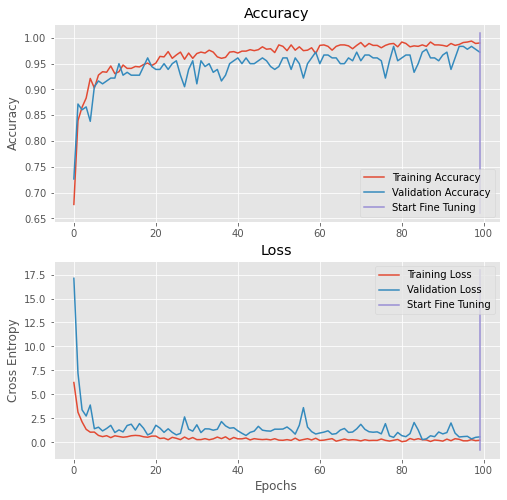

In [23]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot1.pdf")
plt.show()

In [24]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 2.6796 - accuracy: 0.9453

2/5 [===========>..................] - ETA: 2s - loss: 2.0609 - accuracy: 0.9609

3/5 [=================>............] - ETA: 2s - loss: 1.5149 - accuracy: 0.9635

4/5 [=======================>......] - ETA: 1s - loss: 1.3339 - accuracy: 0.9688

5/5 [==============================] - ETA: 0s - loss: 1.2671 - accuracy: 0.9703

5/5 [==============================] - 9s 2s/step - loss: 1.2671 - accuracy: 0.9703


[1.2670865058898926, 0.9703153967857361]

# Fine Tuning

In [25]:
new_model.get_layer('vgg16_features').trainable = False
for layer in new_model.get_layer('vgg16_features').layers:
    for block_name in trainable_blocks:
        if layer.name.startswith(block_name):
            layer.trainable = True
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [26]:
lr_start = lr_min = 1e-5
lr_max = 5e-5

lr_warmup_epochs = 25
lr_exp_decay = 0.8

def lr_schedule(epoch):
    if epoch < lr_warmup_epochs:
        lr = (lr_max - lr_start) / lr_warmup_epochs * epoch + lr_start
    else:
        lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_warmup_epochs) + lr_min
    return lr

cbs = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)]


In [27]:
cbs += [TensorBoard(tb_path)]

In [28]:
epochs=50

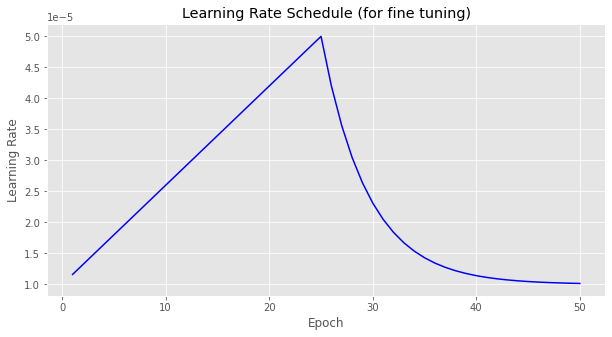

In [29]:
epx = range(1, epochs + 1)
lrs = [lr_schedule(e) for e in epx]
plt.figure(figsize=(10, 5))
plt.plot(epx, lrs, 'b-')
plt.title("Learning Rate Schedule (for fine tuning)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.savefig(path + '/lr_schedule.pdf')
plt.show()

In [30]:
new_model.compile('adam', 'categorical_crossentropy',
               metrics=['accuracy'])

In [31]:
train_ds = dataset(train_path, image_size, crop_size, 64, train=True)

Found 1077 files belonging to 2 classes.


In [32]:
train_history = new_model.fit(train_ds, epochs=init_epochs+epochs, 
                              validation_data=val_ds,
                              initial_epoch=init_epochs,
                              callbacks=cbs,
                              verbose=1)


Epoch 00101: LearningRateScheduler reducing learning rate to 1.0000002156795734e-05.
Epoch 101/150


 1/17 [>.............................] - ETA: 0s - loss: 0.5059 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 4s - loss: 0.4479 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 4s - loss: 0.8789 - accuracy: 0.9688

 4/17 [======>.......................] - ETA: 4s - loss: 0.6591 - accuracy: 0.9766

 5/17 [=======>......................] - ETA: 11s - loss: 0.5592 - accuracy: 0.9750

 6/17 [=========>....................] - ETA: 9s - loss: 0.5711 - accuracy: 0.9766 

 7/17 [===========>..................] - ETA: 13s - loss: 0.5624 - accuracy: 0.9777

 8/17 [=============>................] - ETA: 12s - loss: 0.5014 - accuracy: 0.9785

 9/17 [==============>...............] - ETA: 11s - loss: 0.4457 - accuracy: 0.9809

10/17 [================>.............] - ETA: 11s - loss: 0.4248 - accuracy: 0.9812

11/17 [==================>...........] - ETA: 8s - loss: 0.4431 - accuracy: 0.9787 

12/17 [====================>.........] - ETA: 6s - loss: 0.4371 - accuracy: 0.9779

13/17 [=====================>........] - ETA: 5s - loss: 0.4035 - accuracy: 0.9796

14/17 [=======================>......] - ETA: 3s - loss: 0.3772 - accuracy: 0.9799

15/17 [=========================>....] - ETA: 2s - loss: 0.3972 - accuracy: 0.9792

16/17 [===========================>..] - ETA: 1s - loss: 0.3820 - accuracy: 0.9795

17/17 [==============================] - ETA: 0s - loss: 0.3632 - accuracy: 0.9805

17/17 [==============================] - 22s 1s/step - loss: 0.3632 - accuracy: 0.9805 - val_loss: 0.3795 - val_accuracy: 0.9888



Epoch 00102: LearningRateScheduler reducing learning rate to 1.0000001725436587e-05.
Epoch 102/150


 1/17 [>.............................] - ETA: 0s - loss: 0.3897 - accuracy: 0.9531

 2/17 [==>...........................] - ETA: 15s - loss: 0.2307 - accuracy: 0.9688

 3/17 [====>.........................] - ETA: 20s - loss: 0.1538 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 16s - loss: 0.2079 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 18s - loss: 0.1898 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 14s - loss: 0.1684 - accuracy: 0.9792

 7/17 [===========>..................] - ETA: 17s - loss: 0.1923 - accuracy: 0.9799

 8/17 [=============>................] - ETA: 16s - loss: 0.1683 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 14s - loss: 0.1962 - accuracy: 0.9826

10/17 [================>.............] - ETA: 11s - loss: 0.2092 - accuracy: 0.9812

11/17 [==================>...........] - ETA: 10s - loss: 0.1902 - accuracy: 0.9830

12/17 [====================>.........] - ETA: 7s - loss: 0.1743 - accuracy: 0.9844 

13/17 [=====================>........] - ETA: 5s - loss: 0.1992 - accuracy: 0.9844

14/17 [=======================>......] - ETA: 4s - loss: 0.1850 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.2272 - accuracy: 0.9844

16/17 [===========================>..] - ETA: 1s - loss: 0.2437 - accuracy: 0.9834

17/17 [==============================] - ETA: 0s - loss: 0.2461 - accuracy: 0.9833

17/17 [==============================] - 25s 1s/step - loss: 0.2461 - accuracy: 0.9833 - val_loss: 0.3589 - val_accuracy: 0.9832



Epoch 00103: LearningRateScheduler reducing learning rate to 1.0000001380349271e-05.
Epoch 103/150


 1/17 [>.............................] - ETA: 0s - loss: 0.3490 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 8s - loss: 0.1745 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 17s - loss: 0.1163 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 16s - loss: 0.0872 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 16s - loss: 0.1511 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 13s - loss: 0.1259 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 13s - loss: 0.1079 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 13s - loss: 0.0944 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 12s - loss: 0.1544 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.1440 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.1729 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1790 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1653 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.1535 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1794 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1869 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1806 - accuracy: 0.9898

17/17 [==============================] - 24s 1s/step - loss: 0.1806 - accuracy: 0.9898 - val_loss: 0.3456 - val_accuracy: 0.9832



Epoch 00104: LearningRateScheduler reducing learning rate to 1.0000001104279416e-05.
Epoch 104/150


 1/17 [>.............................] - ETA: 0s - loss: 5.9510e-05 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 7.3407e-05 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 14s - loss: 0.1217 - accuracy: 0.9948   

 4/17 [======>.......................] - ETA: 11s - loss: 0.1468 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 18s - loss: 0.1174 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 15s - loss: 0.1256 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 14s - loss: 0.2418 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 13s - loss: 0.2189 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 12s - loss: 0.2395 - accuracy: 0.9844

10/17 [================>.............] - ETA: 10s - loss: 0.2156 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.2170 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.2021 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 5s - loss: 0.2221 - accuracy: 0.9844

14/17 [=======================>......] - ETA: 4s - loss: 0.2062 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.1925 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.1831 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.1847 - accuracy: 0.9861

17/17 [==============================] - 24s 1s/step - loss: 0.1847 - accuracy: 0.9861 - val_loss: 0.3343 - val_accuracy: 0.9832



Epoch 00105: LearningRateScheduler reducing learning rate to 1.0000000883423533e-05.
Epoch 105/150


 1/17 [>.............................] - ETA: 0s - loss: 0.5316 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 9s - loss: 0.2870 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 20s - loss: 0.2960 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 16s - loss: 0.2639 - accuracy: 0.9766

 5/17 [=======>......................] - ETA: 14s - loss: 0.2202 - accuracy: 0.9781

 6/17 [=========>....................] - ETA: 13s - loss: 0.2032 - accuracy: 0.9766

 7/17 [===========>..................] - ETA: 13s - loss: 0.1769 - accuracy: 0.9777

 8/17 [=============>................] - ETA: 13s - loss: 0.1885 - accuracy: 0.9785

 9/17 [==============>...............] - ETA: 12s - loss: 0.2006 - accuracy: 0.9792

10/17 [================>.............] - ETA: 10s - loss: 0.1936 - accuracy: 0.9797

11/17 [==================>...........] - ETA: 9s - loss: 0.1846 - accuracy: 0.9801 

12/17 [====================>.........] - ETA: 7s - loss: 0.2007 - accuracy: 0.9792

13/17 [=====================>........] - ETA: 5s - loss: 0.2344 - accuracy: 0.9796

14/17 [=======================>......] - ETA: 4s - loss: 0.2188 - accuracy: 0.9799

15/17 [=========================>....] - ETA: 2s - loss: 0.2427 - accuracy: 0.9792

16/17 [===========================>..] - ETA: 1s - loss: 0.2339 - accuracy: 0.9795

17/17 [==============================] - ETA: 0s - loss: 0.2286 - accuracy: 0.9796

17/17 [==============================] - 24s 1s/step - loss: 0.2286 - accuracy: 0.9796 - val_loss: 0.3246 - val_accuracy: 0.9832



Epoch 00106: LearningRateScheduler reducing learning rate to 1.0000000706738827e-05.
Epoch 106/150


 1/17 [>.............................] - ETA: 0s - loss: 0.7810 - accuracy: 0.9375

 2/17 [==>...........................] - ETA: 3s - loss: 0.3905 - accuracy: 0.9688

 3/17 [====>.........................] - ETA: 12s - loss: 0.2658 - accuracy: 0.9740

 4/17 [======>.......................] - ETA: 10s - loss: 0.2648 - accuracy: 0.9766

 5/17 [=======>......................] - ETA: 18s - loss: 0.2119 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 15s - loss: 0.1765 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 12s - loss: 0.2658 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 12s - loss: 0.4235 - accuracy: 0.9785

 9/17 [==============>...............] - ETA: 11s - loss: 0.3765 - accuracy: 0.9809

10/17 [================>.............] - ETA: 10s - loss: 0.3388 - accuracy: 0.9828

11/17 [==================>...........] - ETA: 9s - loss: 0.4289 - accuracy: 0.9801 

12/17 [====================>.........] - ETA: 7s - loss: 0.3932 - accuracy: 0.9818

13/17 [=====================>........] - ETA: 5s - loss: 0.3630 - accuracy: 0.9832

14/17 [=======================>......] - ETA: 4s - loss: 0.3851 - accuracy: 0.9833

15/17 [=========================>....] - ETA: 2s - loss: 0.3594 - accuracy: 0.9844

16/17 [===========================>..] - ETA: 1s - loss: 0.3411 - accuracy: 0.9844

17/17 [==============================] - ETA: 0s - loss: 0.3243 - accuracy: 0.9851

17/17 [==============================] - 23s 1s/step - loss: 0.3243 - accuracy: 0.9851 - val_loss: 0.3422 - val_accuracy: 0.9832



Epoch 00107: LearningRateScheduler reducing learning rate to 1.0000000565391061e-05.
Epoch 107/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 0.1959 - accuracy: 0.9844    

 3/17 [====>.........................] - ETA: 17s - loss: 0.3756 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 15s - loss: 0.3581 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 14s - loss: 0.3175 - accuracy: 0.9781

 6/17 [=========>....................] - ETA: 17s - loss: 0.3263 - accuracy: 0.9766

 7/17 [===========>..................] - ETA: 14s - loss: 0.2798 - accuracy: 0.9799

 8/17 [=============>................] - ETA: 14s - loss: 0.3226 - accuracy: 0.9805

 9/17 [==============>...............] - ETA: 13s - loss: 0.2959 - accuracy: 0.9809

10/17 [================>.............] - ETA: 12s - loss: 0.2677 - accuracy: 0.9812

11/17 [==================>...........] - ETA: 9s - loss: 0.2433 - accuracy: 0.9830 

12/17 [====================>.........] - ETA: 7s - loss: 0.2231 - accuracy: 0.9844

13/17 [=====================>........] - ETA: 5s - loss: 0.2059 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 4s - loss: 0.1912 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.1815 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.1701 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.1618 - accuracy: 0.9879

17/17 [==============================] - 24s 1s/step - loss: 0.1618 - accuracy: 0.9879 - val_loss: 0.3661 - val_accuracy: 0.9832



Epoch 00108: LearningRateScheduler reducing learning rate to 1.0000000452312849e-05.
Epoch 108/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1366 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 17s - loss: 0.0689 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 22s - loss: 0.2682 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 18s - loss: 0.2011 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 15s - loss: 0.1623 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 18s - loss: 0.1795 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 17s - loss: 0.1925 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 14s - loss: 0.1684 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 12s - loss: 0.1497 - accuracy: 0.9896

10/17 [================>.............] - ETA: 10s - loss: 0.1348 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 8s - loss: 0.1225 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1123 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.1071 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.1377 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1285 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1207 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.1231 - accuracy: 0.9916

17/17 [==============================] - 24s 1s/step - loss: 0.1231 - accuracy: 0.9916 - val_loss: 0.3756 - val_accuracy: 0.9832



Epoch 00109: LearningRateScheduler reducing learning rate to 1.000000036185028e-05.
Epoch 109/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2662 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 11s - loss: 0.1518 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 19s - loss: 0.1012 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 15s - loss: 0.0759 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 18s - loss: 0.0607 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 15s - loss: 0.0506 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 14s - loss: 0.0434 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 13s - loss: 0.0387 - accuracy: 0.9961

 9/17 [==============>...............] - ETA: 12s - loss: 0.0344 - accuracy: 0.9965

10/17 [================>.............] - ETA: 10s - loss: 0.0312 - accuracy: 0.9969

11/17 [==================>...........] - ETA: 8s - loss: 0.0283 - accuracy: 0.9972 

12/17 [====================>.........] - ETA: 7s - loss: 0.0264 - accuracy: 0.9974

13/17 [=====================>........] - ETA: 5s - loss: 0.0244 - accuracy: 0.9976

14/17 [=======================>......] - ETA: 4s - loss: 0.0226 - accuracy: 0.9978

15/17 [=========================>....] - ETA: 2s - loss: 0.0623 - accuracy: 0.9948

16/17 [===========================>..] - ETA: 1s - loss: 0.0636 - accuracy: 0.9941

17/17 [==============================] - ETA: 0s - loss: 0.0604 - accuracy: 0.9944

17/17 [==============================] - 24s 1s/step - loss: 0.0604 - accuracy: 0.9944 - val_loss: 0.3857 - val_accuracy: 0.9832



Epoch 00110: LearningRateScheduler reducing learning rate to 1.0000000289480224e-05.
Epoch 110/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0359 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 5s - loss: 0.0185 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 14s - loss: 0.0126 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 15s - loss: 0.0211 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 13s - loss: 0.0169 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 15s - loss: 0.0141 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 12s - loss: 0.0420 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 14s - loss: 0.0430 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 13s - loss: 0.0703 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.1809 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1794 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.1644 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1518 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.1656 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1546 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1477 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1405 - accuracy: 0.9916

17/17 [==============================] - 24s 1s/step - loss: 0.1405 - accuracy: 0.9916 - val_loss: 0.3924 - val_accuracy: 0.9832



Epoch 00111: LearningRateScheduler reducing learning rate to 1.0000000231584179e-05.
Epoch 111/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0493 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 18s - loss: 0.0246 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 16s - loss: 0.0477 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 19s - loss: 0.0358 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 18s - loss: 0.0287 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 15s - loss: 0.1602 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 15s - loss: 0.1846 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.1888 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.2697 - accuracy: 0.9878

10/17 [================>.............] - ETA: 10s - loss: 0.2427 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 8s - loss: 0.2305 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 6s - loss: 0.2114 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1966 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1825 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1856 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.2047 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.2116 - accuracy: 0.9879

17/17 [==============================] - 23s 1s/step - loss: 0.2116 - accuracy: 0.9879 - val_loss: 0.3895 - val_accuracy: 0.9832



Epoch 00112: LearningRateScheduler reducing learning rate to 1.0000000185267343e-05.
Epoch 112/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1541 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 7s - loss: 0.1038 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 6s - loss: 0.0692 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 9s - loss: 0.0524 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 16s - loss: 0.1095 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 14s - loss: 0.0913 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 11s - loss: 0.0782 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 11s - loss: 0.0688 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 11s - loss: 0.0891 - accuracy: 0.9931

10/17 [================>.............] - ETA: 10s - loss: 0.0802 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 8s - loss: 0.0906 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.0830 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.1272 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.1233 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1186 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1112 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1087 - accuracy: 0.9898

17/17 [==============================] - 22s 1s/step - loss: 0.1087 - accuracy: 0.9898 - val_loss: 0.4006 - val_accuracy: 0.9832



Epoch 00113: LearningRateScheduler reducing learning rate to 1.0000000148213875e-05.
Epoch 113/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0667 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 4s - loss: 0.0334 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 11s - loss: 0.0348 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 14s - loss: 0.0267 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 13s - loss: 0.0214 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 16s - loss: 0.0178 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 14s - loss: 0.0153 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 13s - loss: 0.0411 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 11s - loss: 0.0621 - accuracy: 0.9931

10/17 [================>.............] - ETA: 9s - loss: 0.0851 - accuracy: 0.9922 

11/17 [==================>...........] - ETA: 8s - loss: 0.0775 - accuracy: 0.9929

12/17 [====================>.........] - ETA: 7s - loss: 0.0711 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.0656 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 4s - loss: 0.0609 - accuracy: 0.9944

15/17 [=========================>....] - ETA: 2s - loss: 0.0569 - accuracy: 0.9948

16/17 [===========================>..] - ETA: 1s - loss: 0.0938 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.0951 - accuracy: 0.9916

17/17 [==============================] - 23s 1s/step - loss: 0.0951 - accuracy: 0.9916 - val_loss: 0.4045 - val_accuracy: 0.9832



Epoch 00114: LearningRateScheduler reducing learning rate to 1.00000001185711e-05.
Epoch 114/150


 1/17 [>.............................] - ETA: 0s - loss: 1.6829e-05 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 7s - loss: 0.0167 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 7s - loss: 0.0112 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 11s - loss: 0.0084 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 13s - loss: 0.0067 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 12s - loss: 0.0056 - accuracy: 0.9974

 7/17 [===========>..................] - ETA: 11s - loss: 0.0048 - accuracy: 0.9978

 8/17 [=============>................] - ETA: 11s - loss: 0.0380 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 11s - loss: 0.0338 - accuracy: 0.9948

10/17 [================>.............] - ETA: 10s - loss: 0.0304 - accuracy: 0.9953

11/17 [==================>...........] - ETA: 8s - loss: 0.0276 - accuracy: 0.9957 

12/17 [====================>.........] - ETA: 6s - loss: 0.0253 - accuracy: 0.9961

13/17 [=====================>........] - ETA: 5s - loss: 0.0234 - accuracy: 0.9964

14/17 [=======================>......] - ETA: 3s - loss: 0.0319 - accuracy: 0.9944

15/17 [=========================>....] - ETA: 2s - loss: 0.0309 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.0330 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.0314 - accuracy: 0.9935

17/17 [==============================] - 23s 1s/step - loss: 0.0314 - accuracy: 0.9935 - val_loss: 0.4001 - val_accuracy: 0.9832



Epoch 00115: LearningRateScheduler reducing learning rate to 1.0000000094856881e-05.
Epoch 115/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2449 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 9s - loss: 0.1226 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 16s - loss: 0.0817 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 17s - loss: 0.0613 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 14s - loss: 0.0496 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 13s - loss: 0.1861 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 13s - loss: 0.1620 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.1417 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.1260 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.1134 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 8s - loss: 0.1043 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.0956 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.0903 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.1442 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1346 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1262 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1348 - accuracy: 0.9907

17/17 [==============================] - 23s 1s/step - loss: 0.1348 - accuracy: 0.9907 - val_loss: 0.3949 - val_accuracy: 0.9832



Epoch 00116: LearningRateScheduler reducing learning rate to 1.0000000075885505e-05.
Epoch 116/150


 1/17 [>.............................] - ETA: 0s - loss: 5.6614e-06 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 17s - loss: 0.0039 - accuracy: 1.0000   

 3/17 [====>.........................] - ETA: 15s - loss: 0.2748 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 15s - loss: 0.3643 - accuracy: 0.9766

 5/17 [=======>......................] - ETA: 18s - loss: 0.2914 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 15s - loss: 0.3320 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 14s - loss: 0.2846 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 13s - loss: 0.2490 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 12s - loss: 0.2213 - accuracy: 0.9878

10/17 [================>.............] - ETA: 11s - loss: 0.1992 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.2328 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.2255 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.2429 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.2272 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.2502 - accuracy: 0.9844

16/17 [===========================>..] - ETA: 1s - loss: 0.2362 - accuracy: 0.9844

17/17 [==============================] - ETA: 0s - loss: 0.2365 - accuracy: 0.9842

17/17 [==============================] - 24s 1s/step - loss: 0.2365 - accuracy: 0.9842 - val_loss: 0.4080 - val_accuracy: 0.9832



Epoch 00117: LearningRateScheduler reducing learning rate to 1.0000000060708404e-05.
Epoch 117/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2737 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 11s - loss: 0.1580 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 26s - loss: 0.3743 - accuracy: 0.9688

 4/17 [======>.......................] - ETA: 20s - loss: 0.3018 - accuracy: 0.9727

 5/17 [=======>......................] - ETA: 18s - loss: 0.2732 - accuracy: 0.9719

 6/17 [=========>....................] - ETA: 15s - loss: 0.2403 - accuracy: 0.9740

 7/17 [===========>..................] - ETA: 15s - loss: 0.2060 - accuracy: 0.9777

 8/17 [=============>................] - ETA: 13s - loss: 0.1803 - accuracy: 0.9805

 9/17 [==============>...............] - ETA: 11s - loss: 0.1602 - accuracy: 0.9826

10/17 [================>.............] - ETA: 10s - loss: 0.1442 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 8s - loss: 0.1311 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 6s - loss: 0.1202 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.1140 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.1060 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.0989 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1110 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.1202 - accuracy: 0.9861

17/17 [==============================] - 24s 1s/step - loss: 0.1202 - accuracy: 0.9861 - val_loss: 0.4258 - val_accuracy: 0.9832



Epoch 00118: LearningRateScheduler reducing learning rate to 1.0000000048566724e-05.
Epoch 118/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1160 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 12s - loss: 0.0580 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 22s - loss: 0.0850 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 20s - loss: 0.0638 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 16s - loss: 0.1039 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 14s - loss: 0.0866 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 17s - loss: 0.0742 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 16s - loss: 0.0650 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 14s - loss: 0.0577 - accuracy: 0.9948

10/17 [================>.............] - ETA: 11s - loss: 0.0520 - accuracy: 0.9953

11/17 [==================>...........] - ETA: 9s - loss: 0.0473 - accuracy: 0.9957 

12/17 [====================>.........] - ETA: 7s - loss: 0.0893 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.0825 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.0766 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.0715 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.0816 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.0776 - accuracy: 0.9935

17/17 [==============================] - 24s 1s/step - loss: 0.0776 - accuracy: 0.9935 - val_loss: 0.4292 - val_accuracy: 0.9832



Epoch 00119: LearningRateScheduler reducing learning rate to 1.0000000038853378e-05.
Epoch 119/150


 1/17 [>.............................] - ETA: 0s - loss: 3.8775e-06 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 11s - loss: 1.0653e-05 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 16s - loss: 7.1022e-06 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 15s - loss: 0.1681 - accuracy: 0.9883    

 5/17 [=======>......................] - ETA: 16s - loss: 0.1883 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 14s - loss: 0.1732 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 17s - loss: 0.1990 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 16s - loss: 0.1741 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 14s - loss: 0.1551 - accuracy: 0.9878

10/17 [================>.............] - ETA: 13s - loss: 0.1396 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 11s - loss: 0.1269 - accuracy: 0.9901

12/17 [====================>.........] - ETA: 9s - loss: 0.1277 - accuracy: 0.9896 

13/17 [=====================>........] - ETA: 6s - loss: 0.1216 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1129 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 3s - loss: 0.1054 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.0988 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1037 - accuracy: 0.9907

17/17 [==============================] - 28s 2s/step - loss: 0.1037 - accuracy: 0.9907 - val_loss: 0.4329 - val_accuracy: 0.9832



Epoch 00120: LearningRateScheduler reducing learning rate to 1.0000000031082703e-05.
Epoch 120/150


 1/17 [>.............................] - ETA: 0s - loss: 0.7633 - accuracy: 0.9531

 2/17 [==>...........................] - ETA: 17s - loss: 0.6478 - accuracy: 0.9688

 3/17 [====>.........................] - ETA: 17s - loss: 0.5136 - accuracy: 0.9740

 4/17 [======>.......................] - ETA: 15s - loss: 0.4221 - accuracy: 0.9766

 5/17 [=======>......................] - ETA: 20s - loss: 0.3377 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 16s - loss: 0.2859 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 16s - loss: 0.2450 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 14s - loss: 0.2144 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 13s - loss: 0.1906 - accuracy: 0.9878

10/17 [================>.............] - ETA: 10s - loss: 0.1986 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.1825 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.1868 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 5s - loss: 0.1724 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.1601 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1501 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1407 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1415 - accuracy: 0.9889

17/17 [==============================] - 24s 1s/step - loss: 0.1415 - accuracy: 0.9889 - val_loss: 0.4363 - val_accuracy: 0.9832



Epoch 00121: LearningRateScheduler reducing learning rate to 1.0000000024866162e-05.
Epoch 121/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 8s - loss: 3.6787e-07 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 13s - loss: 2.4525e-07 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 16s - loss: 5.1326e-06 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 14s - loss: 0.1816 - accuracy: 0.9875    

 6/17 [=========>....................] - ETA: 16s - loss: 0.1879 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 13s - loss: 0.2027 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 13s - loss: 0.1774 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 12s - loss: 0.1577 - accuracy: 0.9878

10/17 [================>.............] - ETA: 11s - loss: 0.1613 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.1466 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.1650 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.1523 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 4s - loss: 0.1609 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.1502 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.1620 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.1769 - accuracy: 0.9851

17/17 [==============================] - 24s 1s/step - loss: 0.1769 - accuracy: 0.9851 - val_loss: 0.4191 - val_accuracy: 0.9832



Epoch 00122: LearningRateScheduler reducing learning rate to 1.000000001989293e-05.
Epoch 122/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1712 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 3s - loss: 0.0858 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 17s - loss: 0.0809 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 17s - loss: 0.0881 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 13s - loss: 0.0874 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 12s - loss: 0.0769 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 16s - loss: 0.0659 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 15s - loss: 0.0577 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 13s - loss: 0.0523 - accuracy: 0.9896

10/17 [================>.............] - ETA: 10s - loss: 0.0472 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.0429 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1013 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.0935 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.0868 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.0810 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1009 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.0967 - accuracy: 0.9898

17/17 [==============================] - 24s 1s/step - loss: 0.0967 - accuracy: 0.9898 - val_loss: 0.4065 - val_accuracy: 0.9832



Epoch 00123: LearningRateScheduler reducing learning rate to 1.0000000015914344e-05.
Epoch 123/150


 1/17 [>.............................] - ETA: 0s - loss: 2.6000e-06 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 18s - loss: 0.1276 - accuracy: 0.9844   

 3/17 [====>.........................] - ETA: 20s - loss: 0.1396 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 17s - loss: 0.1047 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 14s - loss: 0.0838 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 11s - loss: 0.0699 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 11s - loss: 0.0942 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.0824 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 12s - loss: 0.0859 - accuracy: 0.9913

10/17 [================>.............] - ETA: 10s - loss: 0.0773 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 8s - loss: 0.0972 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.0891 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.0822 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 3s - loss: 0.0764 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.0834 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1167 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1110 - accuracy: 0.9898

17/17 [==============================] - 22s 1s/step - loss: 0.1110 - accuracy: 0.9898 - val_loss: 0.4059 - val_accuracy: 0.9832



Epoch 00124: LearningRateScheduler reducing learning rate to 1.0000000012731475e-05.
Epoch 124/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0633 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 11s - loss: 0.0436 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 25s - loss: 0.2767 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 23s - loss: 0.2722 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 18s - loss: 0.2177 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 16s - loss: 0.2016 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 17s - loss: 0.2775 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 16s - loss: 0.2428 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 14s - loss: 0.2218 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.1997 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 10s - loss: 0.1815 - accuracy: 0.9886

12/17 [====================>.........] - ETA: 7s - loss: 0.1723 - accuracy: 0.9883 

13/17 [=====================>........] - ETA: 5s - loss: 0.1592 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1478 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1466 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1377 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1394 - accuracy: 0.9898

17/17 [==============================] - 25s 1s/step - loss: 0.1394 - accuracy: 0.9898 - val_loss: 0.4092 - val_accuracy: 0.9832



Epoch 00125: LearningRateScheduler reducing learning rate to 1.000000001018518e-05.
Epoch 125/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 6.8309e-04 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 13s - loss: 4.5622e-04 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 16s - loss: 0.0455 - accuracy: 0.9961    

 5/17 [=======>......................] - ETA: 19s - loss: 0.1382 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 16s - loss: 0.1152 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 13s - loss: 0.1381 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.1388 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 10s - loss: 0.1234 - accuracy: 0.9913

10/17 [================>.............] - ETA: 9s - loss: 0.1111 - accuracy: 0.9922 

11/17 [==================>...........] - ETA: 7s - loss: 0.1708 - accuracy: 0.9915

12/17 [====================>.........] - ETA: 6s - loss: 0.1977 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 4s - loss: 0.1825 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.2113 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1972 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.2017 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1918 - accuracy: 0.9907

17/17 [==============================] - 23s 1s/step - loss: 0.1918 - accuracy: 0.9907 - val_loss: 0.4128 - val_accuracy: 0.9832



Epoch 00126: LearningRateScheduler reducing learning rate to 1.0000000008148144e-05.
Epoch 126/150


 1/17 [>.............................] - ETA: 0s - loss: 0.8891 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 10s - loss: 0.5652 - accuracy: 0.9609

 3/17 [====>.........................] - ETA: 21s - loss: 0.3768 - accuracy: 0.9740

 4/17 [======>.......................] - ETA: 20s - loss: 0.3024 - accuracy: 0.9766

 5/17 [=======>......................] - ETA: 18s - loss: 0.2420 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 17s - loss: 0.2016 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 14s - loss: 0.1728 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 13s - loss: 0.1880 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 12s - loss: 0.1671 - accuracy: 0.9878

10/17 [================>.............] - ETA: 10s - loss: 0.1504 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 10s - loss: 0.1367 - accuracy: 0.9901

12/17 [====================>.........] - ETA: 7s - loss: 0.1253 - accuracy: 0.9909 

13/17 [=====================>........] - ETA: 5s - loss: 0.1228 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.1157 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1080 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1126 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1071 - accuracy: 0.9898

17/17 [==============================] - 24s 1s/step - loss: 0.1071 - accuracy: 0.9898 - val_loss: 0.4090 - val_accuracy: 0.9832



Epoch 00127: LearningRateScheduler reducing learning rate to 1.0000000006518516e-05.
Epoch 127/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 10s - loss: 5.2206e-04 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 11s - loss: 0.2773 - accuracy: 0.9896    

 4/17 [======>.......................] - ETA: 9s - loss: 0.2080 - accuracy: 0.9922 

 5/17 [=======>......................] - ETA: 16s - loss: 0.1666 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 13s - loss: 0.1388 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 12s - loss: 0.1614 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.1412 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 11s - loss: 0.1607 - accuracy: 0.9913

10/17 [================>.............] - ETA: 10s - loss: 0.2201 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.2008 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1841 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.1699 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 3s - loss: 0.1578 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.1535 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.1440 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.1369 - accuracy: 0.9935

17/17 [==============================] - 23s 1s/step - loss: 0.1369 - accuracy: 0.9935 - val_loss: 0.3943 - val_accuracy: 0.9832



Epoch 00128: LearningRateScheduler reducing learning rate to 1.0000000005214813e-05.
Epoch 128/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0638 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 5s - loss: 0.0319 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 13s - loss: 0.0213 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 16s - loss: 0.0982 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 17s - loss: 0.1661 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 15s - loss: 0.1384 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 13s - loss: 0.1268 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.1151 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 11s - loss: 0.1023 - accuracy: 0.9913

10/17 [================>.............] - ETA: 9s - loss: 0.0921 - accuracy: 0.9922 

11/17 [==================>...........] - ETA: 8s - loss: 0.0837 - accuracy: 0.9929

12/17 [====================>.........] - ETA: 6s - loss: 0.0925 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.0869 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 3s - loss: 0.0818 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.0763 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.0762 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.9916

17/17 [==============================] - 23s 1s/step - loss: 0.0725 - accuracy: 0.9916 - val_loss: 0.3993 - val_accuracy: 0.9832



Epoch 00129: LearningRateScheduler reducing learning rate to 1.000000000417185e-05.
Epoch 129/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2681 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 3s - loss: 0.1755 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 13s - loss: 0.1696 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 13s - loss: 0.1273 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 17s - loss: 0.1189 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 14s - loss: 0.0998 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 16s - loss: 0.2089 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 15s - loss: 0.1828 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 13s - loss: 0.1625 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.1463 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.1330 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.1305 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.1204 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1118 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1044 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.0979 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.0961 - accuracy: 0.9907

17/17 [==============================] - 24s 1s/step - loss: 0.0961 - accuracy: 0.9907 - val_loss: 0.4160 - val_accuracy: 0.9832



Epoch 00130: LearningRateScheduler reducing learning rate to 1.000000000333748e-05.
Epoch 130/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0054 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 5s - loss: 0.0027 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 17s - loss: 0.0018 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 15s - loss: 0.0014 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 13s - loss: 0.0477 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 15s - loss: 0.0397 - accuracy: 0.9974

 7/17 [===========>..................] - ETA: 12s - loss: 0.0341 - accuracy: 0.9978

 8/17 [=============>................] - ETA: 12s - loss: 0.0600 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 10s - loss: 0.0534 - accuracy: 0.9948

10/17 [================>.............] - ETA: 9s - loss: 0.1122 - accuracy: 0.9937 

11/17 [==================>...........] - ETA: 8s - loss: 0.1050 - accuracy: 0.9929

12/17 [====================>.........] - ETA: 6s - loss: 0.0963 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.0891 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 3s - loss: 0.0844 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.0788 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.1041 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.0990 - accuracy: 0.9935

17/17 [==============================] - 23s 1s/step - loss: 0.0990 - accuracy: 0.9935 - val_loss: 0.4216 - val_accuracy: 0.9832



Epoch 00131: LearningRateScheduler reducing learning rate to 1.0000000002669984e-05.
Epoch 131/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0091 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 0.0797 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 17s - loss: 0.0531 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 13s - loss: 0.0399 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 13s - loss: 0.0769 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 15s - loss: 0.1466 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 13s - loss: 0.1275 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 14s - loss: 0.1116 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 13s - loss: 0.0992 - accuracy: 0.9931

10/17 [================>.............] - ETA: 10s - loss: 0.1138 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.1035 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.0949 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.0876 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 4s - loss: 0.1126 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.1051 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.1396 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.1327 - accuracy: 0.9926

17/17 [==============================] - 24s 1s/step - loss: 0.1327 - accuracy: 0.9926 - val_loss: 0.4249 - val_accuracy: 0.9832



Epoch 00132: LearningRateScheduler reducing learning rate to 1.0000000002135988e-05.
Epoch 132/150


 1/17 [>.............................] - ETA: 0s - loss: 0.5454 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 17s - loss: 0.4301 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 21s - loss: 0.3561 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 16s - loss: 0.5497 - accuracy: 0.9727

 5/17 [=======>......................] - ETA: 20s - loss: 0.4398 - accuracy: 0.9781

 6/17 [=========>....................] - ETA: 16s - loss: 0.3665 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 15s - loss: 0.3230 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 13s - loss: 0.2826 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 12s - loss: 0.2512 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.2268 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.2062 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.1890 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1874 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1753 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1845 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1730 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1648 - accuracy: 0.9898

17/17 [==============================] - 24s 1s/step - loss: 0.1648 - accuracy: 0.9898 - val_loss: 0.4263 - val_accuracy: 0.9832



Epoch 00133: LearningRateScheduler reducing learning rate to 1.000000000170879e-05.
Epoch 133/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 14s - loss: 0.0106 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 21s - loss: 0.0596 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 23s - loss: 0.0447 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 20s - loss: 0.1086 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 17s - loss: 0.1033 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 14s - loss: 0.1121 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.1207 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 11s - loss: 0.1474 - accuracy: 0.9878

10/17 [================>.............] - ETA: 10s - loss: 0.1408 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 8s - loss: 0.1280 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.1173 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1083 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.1006 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.0938 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.0880 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.0837 - accuracy: 0.9926

17/17 [==============================] - 24s 1s/step - loss: 0.0837 - accuracy: 0.9926 - val_loss: 0.4487 - val_accuracy: 0.9832



Epoch 00134: LearningRateScheduler reducing learning rate to 1.0000000001367032e-05.
Epoch 134/150


 1/17 [>.............................] - ETA: 0s - loss: 4.8623e-05 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 12s - loss: 2.4312e-05 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 21s - loss: 3.3685e-04 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 20s - loss: 2.5294e-04 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 18s - loss: 0.0184 - accuracy: 0.9969    

 6/17 [=========>....................] - ETA: 17s - loss: 0.0493 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 14s - loss: 0.0423 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 13s - loss: 0.1034 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 11s - loss: 0.1604 - accuracy: 0.9913

10/17 [================>.............] - ETA: 10s - loss: 0.1793 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 8s - loss: 0.1630 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 6s - loss: 0.1533 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1415 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.1314 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1227 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.1150 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.1233 - accuracy: 0.9916

17/17 [==============================] - 23s 1s/step - loss: 0.1233 - accuracy: 0.9916 - val_loss: 0.4587 - val_accuracy: 0.9832



Epoch 00135: LearningRateScheduler reducing learning rate to 1.0000000001093625e-05.
Epoch 135/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2146 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 4s - loss: 0.1505 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 17s - loss: 0.3745 - accuracy: 0.9740

 4/17 [======>.......................] - ETA: 15s - loss: 0.2826 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 16s - loss: 0.2261 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 13s - loss: 0.1888 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 16s - loss: 0.1715 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 14s - loss: 0.2244 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 13s - loss: 0.2757 - accuracy: 0.9826

10/17 [================>.............] - ETA: 11s - loss: 0.2482 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 9s - loss: 0.2735 - accuracy: 0.9830 

12/17 [====================>.........] - ETA: 7s - loss: 0.3177 - accuracy: 0.9818

13/17 [=====================>........] - ETA: 5s - loss: 0.3533 - accuracy: 0.9808

14/17 [=======================>......] - ETA: 4s - loss: 0.3282 - accuracy: 0.9821

15/17 [=========================>....] - ETA: 2s - loss: 0.3077 - accuracy: 0.9823

16/17 [===========================>..] - ETA: 1s - loss: 0.2885 - accuracy: 0.9834

17/17 [==============================] - ETA: 0s - loss: 0.2743 - accuracy: 0.9842

17/17 [==============================] - 23s 1s/step - loss: 0.2743 - accuracy: 0.9842 - val_loss: 0.4634 - val_accuracy: 0.9832



Epoch 00136: LearningRateScheduler reducing learning rate to 1.0000000000874901e-05.
Epoch 136/150


 1/17 [>.............................] - ETA: 0s - loss: 1.4901e-08 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 11s - loss: 1.2107e-08 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 14s - loss: 0.0046 - accuracy: 0.9948    

 4/17 [======>.......................] - ETA: 16s - loss: 0.0035 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 16s - loss: 0.0028 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 13s - loss: 0.0554 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 16s - loss: 0.0631 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 15s - loss: 0.0838 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 13s - loss: 0.0745 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.0674 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.0820 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.1627 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.2020 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.1876 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1751 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1710 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1626 - accuracy: 0.9889

17/17 [==============================] - 24s 1s/step - loss: 0.1626 - accuracy: 0.9889 - val_loss: 0.4657 - val_accuracy: 0.9832



Epoch 00137: LearningRateScheduler reducing learning rate to 1.0000000000699921e-05.
Epoch 137/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2326 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 18s - loss: 0.1163 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 20s - loss: 0.3872 - accuracy: 0.9688

 4/17 [======>.......................] - ETA: 15s - loss: 0.2904 - accuracy: 0.9766

 5/17 [=======>......................] - ETA: 17s - loss: 0.2368 - accuracy: 0.9781

 6/17 [=========>....................] - ETA: 16s - loss: 0.1973 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 17s - loss: 0.1692 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 15s - loss: 0.1653 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 14s - loss: 0.1470 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.1419 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.1320 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.1210 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.1253 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.1170 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1095 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1027 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.0976 - accuracy: 0.9898

17/17 [==============================] - 24s 1s/step - loss: 0.0976 - accuracy: 0.9898 - val_loss: 0.4618 - val_accuracy: 0.9832



Epoch 00138: LearningRateScheduler reducing learning rate to 1.0000000000559937e-05.
Epoch 138/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 11s - loss: 0.0090 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 15s - loss: 0.0060 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 23s - loss: 0.0045 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 20s - loss: 0.0754 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 17s - loss: 0.0633 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 14s - loss: 0.0916 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 13s - loss: 0.0912 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.0810 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.0729 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.0663 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.1033 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.0954 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.0886 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.0959 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.0899 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.0855 - accuracy: 0.9935

17/17 [==============================] - 24s 1s/step - loss: 0.0855 - accuracy: 0.9935 - val_loss: 0.4613 - val_accuracy: 0.9832



Epoch 00139: LearningRateScheduler reducing learning rate to 1.0000000000447949e-05.
Epoch 139/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 0.0000e+00 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 18s - loss: 0.0209 - accuracy: 0.9948   

 4/17 [======>.......................] - ETA: 14s - loss: 0.0507 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 14s - loss: 0.0405 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 17s - loss: 0.0489 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 16s - loss: 0.0419 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 15s - loss: 0.0535 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 14s - loss: 0.0680 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.0653 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1076 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.0987 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.0953 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.0885 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.0826 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.0909 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.0885 - accuracy: 0.9907

17/17 [==============================] - 24s 1s/step - loss: 0.0885 - accuracy: 0.9907 - val_loss: 0.4407 - val_accuracy: 0.9832



Epoch 00140: LearningRateScheduler reducing learning rate to 1.000000000035836e-05.
Epoch 140/150


 1/17 [>.............................] - ETA: 0s - loss: 1.8626e-09 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 0.0577 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 18s - loss: 0.0607 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 14s - loss: 0.0971 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 19s - loss: 0.0776 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 17s - loss: 0.0827 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 14s - loss: 0.0709 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.1028 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 10s - loss: 0.0914 - accuracy: 0.9913

10/17 [================>.............] - ETA: 9s - loss: 0.0823 - accuracy: 0.9922 

11/17 [==================>...........] - ETA: 7s - loss: 0.0748 - accuracy: 0.9929

12/17 [====================>.........] - ETA: 6s - loss: 0.0685 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 4s - loss: 0.0633 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 3s - loss: 0.0588 - accuracy: 0.9944

15/17 [=========================>....] - ETA: 2s - loss: 0.0549 - accuracy: 0.9948

16/17 [===========================>..] - ETA: 1s - loss: 0.0671 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.0638 - accuracy: 0.9935

17/17 [==============================] - 22s 1s/step - loss: 0.0638 - accuracy: 0.9935 - val_loss: 0.4290 - val_accuracy: 0.9832



Epoch 00141: LearningRateScheduler reducing learning rate to 1.0000000000286688e-05.
Epoch 141/150


 1/17 [>.............................] - ETA: 0s - loss: 2.9073e-06 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 1.4620e-06 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 13s - loss: 0.0641 - accuracy: 0.9896   

 4/17 [======>.......................] - ETA: 13s - loss: 0.0481 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 14s - loss: 0.0419 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 13s - loss: 0.0413 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 16s - loss: 0.0354 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 15s - loss: 0.0819 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 13s - loss: 0.0728 - accuracy: 0.9913

10/17 [================>.............] - ETA: 12s - loss: 0.0655 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.0596 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.0897 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.1163 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.1080 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1008 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.1022 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.0972 - accuracy: 0.9926

17/17 [==============================] - 24s 1s/step - loss: 0.0972 - accuracy: 0.9926 - val_loss: 0.4287 - val_accuracy: 0.9832



Epoch 00142: LearningRateScheduler reducing learning rate to 1.000000000022935e-05.
Epoch 142/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 5s - loss: 0.0340 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 17s - loss: 0.0389 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 13s - loss: 0.0292 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 18s - loss: 0.1743 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 15s - loss: 0.1453 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 13s - loss: 0.1394 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.1219 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 11s - loss: 0.1084 - accuracy: 0.9913

10/17 [================>.............] - ETA: 10s - loss: 0.1202 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1095 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1004 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.0927 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 3s - loss: 0.0860 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.0803 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.0753 - accuracy: 0.9941

17/17 [==============================] - ETA: 0s - loss: 0.0716 - accuracy: 0.9944

17/17 [==============================] - 23s 1s/step - loss: 0.0716 - accuracy: 0.9944 - val_loss: 0.4283 - val_accuracy: 0.9832



Epoch 00143: LearningRateScheduler reducing learning rate to 1.000000000018348e-05.
Epoch 143/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 9s - loss: 0.0000e+00 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 23s - loss: 0.0965 - accuracy: 0.9896   

 4/17 [======>.......................] - ETA: 18s - loss: 0.0725 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 14s - loss: 0.0586 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 13s - loss: 0.0488 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 14s - loss: 0.0419 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 13s - loss: 0.0366 - accuracy: 0.9961

 9/17 [==============>...............] - ETA: 12s - loss: 0.1108 - accuracy: 0.9931

10/17 [================>.............] - ETA: 10s - loss: 0.1252 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.1491 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.1490 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1385 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1527 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1425 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1336 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1270 - accuracy: 0.9898

17/17 [==============================] - 24s 1s/step - loss: 0.1270 - accuracy: 0.9898 - val_loss: 0.4264 - val_accuracy: 0.9832



Epoch 00144: LearningRateScheduler reducing learning rate to 1.0000000000146785e-05.
Epoch 144/150


 1/17 [>.............................] - ETA: 0s - loss: 0.3506 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 5s - loss: 0.1753 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 13s - loss: 0.1256 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 19s - loss: 0.1123 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 15s - loss: 0.1022 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 15s - loss: 0.0851 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 13s - loss: 0.1019 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.2781 - accuracy: 0.9805

 9/17 [==============>...............] - ETA: 12s - loss: 0.2878 - accuracy: 0.9792

10/17 [================>.............] - ETA: 10s - loss: 0.2590 - accuracy: 0.9812

11/17 [==================>...........] - ETA: 9s - loss: 0.2356 - accuracy: 0.9830 

12/17 [====================>.........] - ETA: 7s - loss: 0.2160 - accuracy: 0.9844

13/17 [=====================>........] - ETA: 5s - loss: 0.1994 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 4s - loss: 0.1882 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.1757 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.1647 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.1566 - accuracy: 0.9879

17/17 [==============================] - 24s 1s/step - loss: 0.1566 - accuracy: 0.9879 - val_loss: 0.4227 - val_accuracy: 0.9832



Epoch 00145: LearningRateScheduler reducing learning rate to 1.0000000000117428e-05.
Epoch 145/150


 1/17 [>.............................] - ETA: 0s - loss: 1.1462e-05 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 13s - loss: 0.0054 - accuracy: 1.0000   

 3/17 [====>.........................] - ETA: 16s - loss: 0.0036 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 20s - loss: 0.0027 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 16s - loss: 0.0295 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 15s - loss: 0.0651 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 15s - loss: 0.0853 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.0746 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 11s - loss: 0.0664 - accuracy: 0.9931

10/17 [================>.............] - ETA: 10s - loss: 0.1234 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 8s - loss: 0.1178 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 6s - loss: 0.1080 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1149 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.1067 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.0996 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1038 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1103 - accuracy: 0.9907

17/17 [==============================] - 23s 1s/step - loss: 0.1103 - accuracy: 0.9907 - val_loss: 0.4384 - val_accuracy: 0.9832



Epoch 00146: LearningRateScheduler reducing learning rate to 1.0000000000093942e-05.
Epoch 146/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 15s - loss: 0.0440 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 16s - loss: 0.0293 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 13s - loss: 0.0220 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 13s - loss: 0.0176 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 12s - loss: 0.0147 - accuracy: 0.9974

 7/17 [===========>..................] - ETA: 16s - loss: 0.0126 - accuracy: 0.9978

 8/17 [=============>................] - ETA: 15s - loss: 0.0110 - accuracy: 0.9980

 9/17 [==============>...............] - ETA: 13s - loss: 0.0098 - accuracy: 0.9983

10/17 [================>.............] - ETA: 11s - loss: 0.0131 - accuracy: 0.9969

11/17 [==================>...........] - ETA: 9s - loss: 0.0132 - accuracy: 0.9957 

12/17 [====================>.........] - ETA: 7s - loss: 0.0165 - accuracy: 0.9948

13/17 [=====================>........] - ETA: 5s - loss: 0.0158 - accuracy: 0.9952

14/17 [=======================>......] - ETA: 4s - loss: 0.0147 - accuracy: 0.9955

15/17 [=========================>....] - ETA: 2s - loss: 0.0149 - accuracy: 0.9948

16/17 [===========================>..] - ETA: 1s - loss: 0.0140 - accuracy: 0.9951

17/17 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 0.9935

17/17 [==============================] - 23s 1s/step - loss: 0.0274 - accuracy: 0.9935 - val_loss: 0.4469 - val_accuracy: 0.9832



Epoch 00147: LearningRateScheduler reducing learning rate to 1.0000000000075155e-05.
Epoch 147/150


 1/17 [>.............................] - ETA: 0s - loss: 1.7806e-06 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 7s - loss: 9.2568e-07 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 19s - loss: 2.7464e-04 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 14s - loss: 6.5760e-04 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 17s - loss: 6.3150e-04 - accuracy: 1.0000

 6/17 [=========>....................] - ETA: 14s - loss: 0.0766 - accuracy: 0.9948    

 7/17 [===========>..................] - ETA: 13s - loss: 0.0657 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 13s - loss: 0.1027 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 12s - loss: 0.0913 - accuracy: 0.9948

10/17 [================>.............] - ETA: 9s - loss: 0.0984 - accuracy: 0.9922 

11/17 [==================>...........] - ETA: 8s - loss: 0.1122 - accuracy: 0.9915

12/17 [====================>.........] - ETA: 6s - loss: 0.1029 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.0950 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 3s - loss: 0.1233 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1151 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.1079 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.1026 - accuracy: 0.9935

17/17 [==============================] - 23s 1s/step - loss: 0.1026 - accuracy: 0.9935 - val_loss: 0.4441 - val_accuracy: 0.9832



Epoch 00148: LearningRateScheduler reducing learning rate to 1.0000000000060123e-05.
Epoch 148/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 0.0420 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 17s - loss: 0.0938 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 13s - loss: 0.0704 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 14s - loss: 0.0563 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 13s - loss: 0.0469 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 13s - loss: 0.0402 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 13s - loss: 0.0395 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 12s - loss: 0.0408 - accuracy: 0.9931

10/17 [================>.............] - ETA: 10s - loss: 0.0544 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.0714 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1204 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1112 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.1032 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1375 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1290 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.1254 - accuracy: 0.9916

17/17 [==============================] - 24s 1s/step - loss: 0.1254 - accuracy: 0.9916 - val_loss: 0.4426 - val_accuracy: 0.9832



Epoch 00149: LearningRateScheduler reducing learning rate to 1.0000000000048099e-05.
Epoch 149/150


 1/17 [>.............................] - ETA: 0s - loss: 0.4358 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 4s - loss: 0.2179 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 11s - loss: 0.1453 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 13s - loss: 0.1090 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 16s - loss: 0.0964 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 13s - loss: 0.1211 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 13s - loss: 0.1038 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 12s - loss: 0.1384 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 10s - loss: 0.1361 - accuracy: 0.9878

10/17 [================>.............] - ETA: 9s - loss: 0.1822 - accuracy: 0.9859 

11/17 [==================>...........] - ETA: 7s - loss: 0.1656 - accuracy: 0.9872

12/17 [====================>.........] - ETA: 6s - loss: 0.1711 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.1579 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 3s - loss: 0.1467 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1369 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1380 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1312 - accuracy: 0.9898

17/17 [==============================] - 23s 1s/step - loss: 0.1312 - accuracy: 0.9898 - val_loss: 0.4513 - val_accuracy: 0.9832



Epoch 00150: LearningRateScheduler reducing learning rate to 1.000000000003848e-05.
Epoch 150/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 10s - loss: 0.0596 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 26s - loss: 0.0397 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 20s - loss: 0.0298 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 16s - loss: 0.0238 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 16s - loss: 0.0610 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 18s - loss: 0.0523 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 14s - loss: 0.0765 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 15s - loss: 0.0680 - accuracy: 0.9948

10/17 [================>.............] - ETA: 12s - loss: 0.0726 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 10s - loss: 0.0660 - accuracy: 0.9943

12/17 [====================>.........] - ETA: 8s - loss: 0.0605 - accuracy: 0.9948 

13/17 [=====================>........] - ETA: 6s - loss: 0.0558 - accuracy: 0.9952

14/17 [=======================>......] - ETA: 4s - loss: 0.0633 - accuracy: 0.9944

15/17 [=========================>....] - ETA: 2s - loss: 0.0591 - accuracy: 0.9948

16/17 [===========================>..] - ETA: 1s - loss: 0.0555 - accuracy: 0.9951

17/17 [==============================] - ETA: 0s - loss: 0.0528 - accuracy: 0.9954

17/17 [==============================] - 25s 1s/step - loss: 0.0528 - accuracy: 0.9954 - val_loss: 0.4489 - val_accuracy: 0.9832


In [33]:
new_model.save_weights(path + '/finetuned_model.h5')

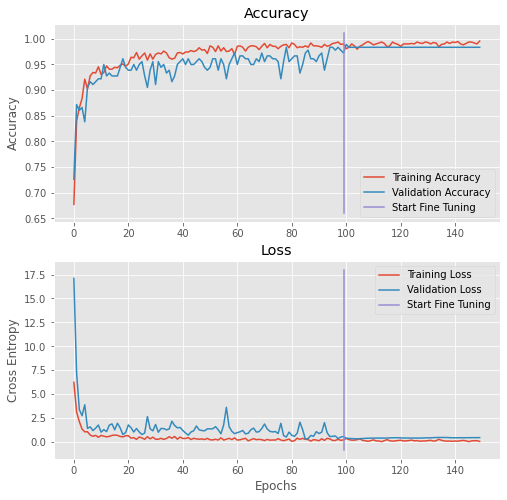

In [34]:
acc += train_history.history['accuracy']
val_acc += train_history.history['val_accuracy']

loss += train_history.history['loss']
val_loss += train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot2.pdf")
plt.show()

In [35]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 2.7784 - accuracy: 0.9375

2/5 [===========>..................] - ETA: 2s - loss: 1.7506 - accuracy: 0.9492

3/5 [=================>............] - ETA: 2s - loss: 1.2054 - accuracy: 0.9635

4/5 [=======================>......] - ETA: 1s - loss: 1.0403 - accuracy: 0.9707

5/5 [==============================] - ETA: 0s - loss: 0.9882 - accuracy: 0.9722

5/5 [==============================] - 6s 1s/step - loss: 0.9882 - accuracy: 0.9722


[0.9881877303123474, 0.9721707105636597]

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

y_true, y_pred = [], []
for images, labels in test_ds:
    preds = new_model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append(preds)

y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
y_probas = y_pred
y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
print('Accuracy: ', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy:  0.9721706864564007
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       158
           1       0.97      0.99      0.98       381

    accuracy                           0.97       539
   macro avg       0.97      0.96      0.97       539
weighted avg       0.97      0.97      0.97       539



In [37]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc

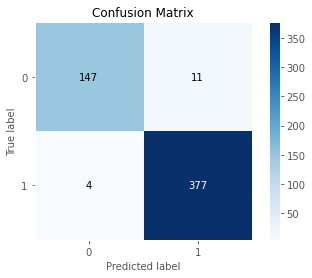

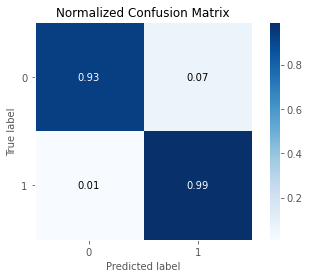

In [38]:
plot_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred, normalize=True)

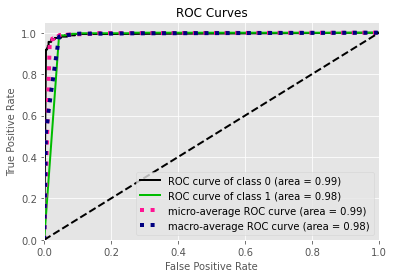

In [39]:
plot_roc(y_true, y_probas)

In [40]:
from imblearn.metrics import classification_report_imbalanced

Using TensorFlow backend.


In [41]:
print(classification_report(y_true, y_pred))
print(classification_report_imbalanced(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       158
           1       0.97      0.99      0.98       381

    accuracy                           0.97       539
   macro avg       0.97      0.96      0.97       539
weighted avg       0.97      0.97      0.97       539

                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.93      0.99      0.95      0.96      0.92       158
          1       0.97      0.99      0.93      0.98      0.96      0.93       381

avg / total       0.97      0.97      0.95      0.97      0.96      0.92       539

